In [1]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 66 kB 866 kB/s 
     |████████████████████████████████| 58 kB 2.3 MB/s 
     |████████████████████████████████| 244 kB 4.7 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=5c92d2a75eaf78fa525270ae12c0be6ebd6b045ae4179b5e67e83f0884c6fd6a
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=c2db8cfa090ceb8baf1107de2c3f6caf7459b3badd7c8c3f191722deba703e82
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pathlib
import sys
import os
import random
import time
import numba
import cv2
import gc 
from tqdm.notebook import tqdm 
from sklearn.model_selection import KFold

#data structure
import pandas as pd

#graphics
import matplotlib.pyplot as plt
%matplotlib inline

#tiff file
import rasterio 
from rasterio.windows import Window 
from rasterio.enums import Resampling

#models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import segmentation_models_pytorch as smp

#data augmentation
import albumentations as A 
import torchvision
from torchvision import transforms as T

In [3]:
!mkdir -p /tmp/pip/cache/
!cp ../input/segmentationmodelspytorch/segmentation_models/efficientnet_pytorch-0.6.3.xyz /tmp/pip/cache/efficientnet_pytorch-0.6.3.tar.gz
!cp ../input/segmentationmodelspytorch/segmentation_models/pretrainedmodels-0.7.4.xyz /tmp/pip/cache/pretrainedmodels-0.7.4.tar.gz
!cp ../input/segmentationmodelspytorch/segmentation_models/segmentation-models-pytorch-0.1.2.xyz /tmp/pip/cache/segmentation_models_pytorch-0.1.2.tar.gz
!cp ../input/segmentationmodelspytorch/segmentation_models/timm-0.1.20-py3-none-any.whl /tmp/pip/cache/
!cp ../input/segmentationmodelspytorch/segmentation_models/timm-0.2.1-py3-none-any.whl /tmp/pip/cache/
!pip install --no-index --find-links /tmp/pip/cache/ efficientnet-pytorch
!pip install --no-index --find-links /tmp/pip/cache/ segmentation-models-pytorch

Looking in links: /tmp/pip/cache/
Looking in links: /tmp/pip/cache/


In [4]:
def set_seeds(seed=21):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
BASE_DIR = '../input/hubmap-kidney-segmentation'
SAVE_DIR = "/kaggle/working/"
SEED = 21
WINDOW = 1024
NEW_SIZE = 256
OVERLAP = 32 
EPOCHS = 15
BATCH_SIZE = 16
NUM_WORKERS = 4
REDUCE_RATE = 4
THRESHOLD = 50
NFOLDS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

torch.cuda.empty_cache()
set_seeds();

In [6]:
# used for converting the decoded image to rle mask
def mask2rle(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = (np.asarray(pixels[1:] != pixels[:-1]).nonzero())[0] + 1
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(NEW_SIZE, NEW_SIZE)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

#voir ce que fait cette fonction --> numba optimisé
@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: 
        points.append(0)
    flag = True
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if flag:
                points.append(i+1)
                flag = False
            else:
                points.append(i+1 - points[-1])
                flag = True
    if pixels[-1] == 1: 
        points.append(size-points[-1]+1)    
    return points

def rle_numba_encode(image):
    pixels = image.T.flatten()
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=WINDOW, min_overlap=OVERLAP):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    
    nx = x // (window - min_overlap) + 1 # + 1 seulement si division reste 0?
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x) #assert x1.size == x2.size ?
    
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [7]:
identity = rasterio.Affine(1, 0, 0, 0, 1, 0)

#enlever mode si testdataset pas possible
class HubDataset(D.Dataset):
    def __init__(self, mode, transform=None, preprocessing=None):
        self.mode = mode #train or test
        self.transform = transform
        self.preprocessing = preprocessing
        #ajouter preprocessing
        name_csv = 'train.csv' if mode=='train' else 'sample_submission.csv'
        self.csv = pd.read_csv(f"{BASE_DIR}/{name_csv}", index_col=[0])
        
        self.x, self.y = [], []
        self.build_slices()
    
    def build_slices(self):
        self.masks = []
        self.files = []
        self.slices = []
        for i, file_id in enumerate(self.csv.index.values):
            filepath = f'{BASE_DIR}/{self.mode}/{file_id}.tiff'
            self.files.append(filepath)
                                 
            print('Transform', filepath)
            with rasterio.open(filepath, transform=identity, driver='GTiff') as dataset:   
                if self.mode == 'train':
                    self.masks.append(rle2mask(self.csv.loc[file_id, 'encoding'], dataset.shape))
                
                slices = make_grid(dataset.shape, window=WINDOW, min_overlap=OVERLAP)
                for (x1,x2,y1,y2) in tqdm(slices):
                    use_slice = self.masks[-1][x1:x2,y1:y2].sum() > THRESHOLD if self.mode=='train' else True
                    if use_slice: 
                        self.slices.append([i,x1,x2,y1,y2])
                        image = dataset.read([1, 2, 3], #(r, g, b), h, w
                            window=Window.from_slices((x1,x2),(y1,y2)))
                        image = np.moveaxis(image, 0, -1) # h, w, (r, g, b)              
                        self.x.append(image)
                        
                        if self.mode == 'train':
                            mask = self.masks[-1][x1:x2,y1:y2]
                            mask = np.expand_dims(mask, axis=2)
                            self.y.append(mask)
    
    # get data operation
    def __getitem__(self, index):
        if self.mode == 'train':
            image, mask = self.x[index], self.y[index] #h, w, (r, g, b)
            if self.transform:
                augments = self.transform(image=image, mask=mask) #h, w, (r, g, b)
                image, mask = augments['image'], augments['mask']
            if self.preprocessing:
                preproc = self.preprocessing(image=image, mask=mask) #(r, g, b), h, w 
                image, mask = preproc['image'], preproc['mask']
            return image, mask
        
        else:
            image = self.x[index]
            if self.transform:
                augments = self.transform(image=image)
                image = augments['image']
            if self.preprocessing:
                preproc = self.preprocessing(image=image)
                image, mask = preproc['image']
            return image
    
    def __len__(self):
        return len(self.x)

In [8]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32') 

def get_preprocessing():
    _transform = [
        #A.Resize(380)
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225),
                    max_pixel_value=255.0, always_apply=True, p=1.0),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

# A. Datasets and loaders 

In [9]:
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        
        A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, shift_limit=0.2, p=0.2, border_mode=0),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        
        A.Compose([
            A.VerticalFlip(p=0.5),              
            A.RandomRotate90(p=0.5)]
        )
    ]
    return A.Compose(train_transform)


In [10]:
trfm = A.Compose([
    A.Resize(NEW_SIZE,NEW_SIZE),
    #A.HorizontalFlip(p=0.5),
    #A.VerticalFlip(p=0.5),
    
    #A.OneOf([
    #    A.RandomContrast(),
    #    A.RandomGamma(),
    #    A.RandomBrightness(),
    #    A.ColorJitter(brightness=0.07, contrast=0.07,
    #               saturation=0.1, hue=0.1, always_apply=False, p=0.3),
    #    ], p=0.3),
    #A.OneOf([
    #    A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    #    A.GridDistortion(),
    #    A.OpticalDistortion(distort_limit=2, shift_limit=0.5),
    #    ], p=0.0),
    #A.ShiftScaleRotate(),
])

#resolution 380 et channels poyr efficient net B4
#preprocess_input = get_preprocessing_fn('efficientnet-b4', pretrained='imagenet')

ds = HubDataset('train', transform=trfm, preprocessing=get_preprocessing())

Transform ../input/hubmap-kidney-segmentation/train/2f6ecfcdf.tiff


/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Transform ../input/hubmap-kidney-segmentation/train/aaa6a05cc.tiff



Transform ../input/hubmap-kidney-segmentation/train/cb2d976f4.tiff



Transform ../input/hubmap-kidney-segmentation/train/0486052bb.tiff



Transform ../input/hubmap-kidney-segmentation/train/e79de561c.tiff



Transform ../input/hubmap-kidney-segmentation/train/095bf7a1f.tiff



Transform ../input/hubmap-kidney-segmentation/train/54f2eec69.tiff



Transform ../input/hubmap-kidney-segmentation/train/1e2425f28.tiff


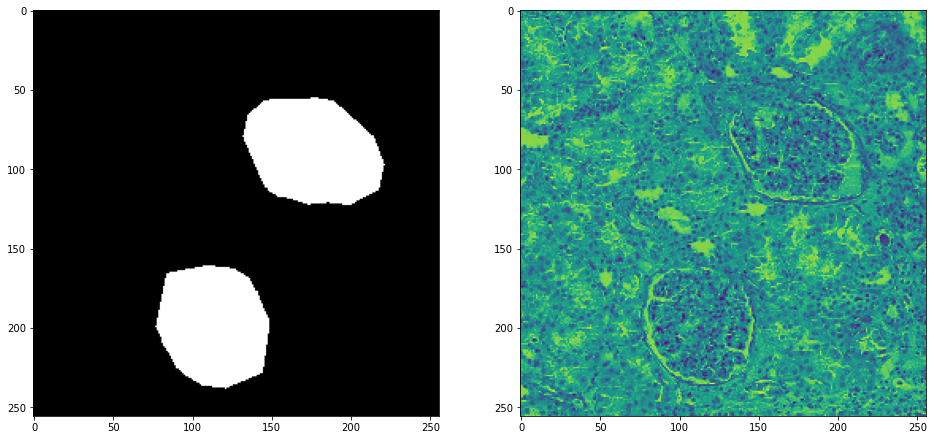

In [11]:
image, mask = ds[2]
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(mask[0], cmap='gray')
plt.subplot(122)
plt.imshow(image[0]);

_ = rle_numba_encode(mask[0]) # compile function with numba

# B. Model

In [12]:
#https://github.com/qubvel/segmentation_models.pytorch#encoders
ENCODER = 'efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet' #ssl, swsl
ACTIVATION = 'sigmoid' 
DROPOUT = 0.5
POOLING = 'avg'

def get_model():
    model = smp.Unet( #UnetPlusPlus ??
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS,
        activation = ACTIVATION,
        in_channels=3,
        classes=1)
    #dropout=DROPOUT,
    #pooling=POOLING
    
    return model

In [13]:
# changer dice loss et iou par moyenne bcedigit et dice loss

In [14]:
model = get_model()

#model.to(DEVICE);

#optimizer = torch.optim.AdamW(model.parameters(),
#                  lr=1e-4, weight_decay=1e-3)

#utiliser d'abord entropie croisée (bce log digits)
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    #dice
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


In [15]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)


Epoch: 0
valid: 100%|██████████| 23/23 [00:04<00:00,  5.35it/s, dice_loss - 0.6124, iou_score - 0.5594]
Model saved!


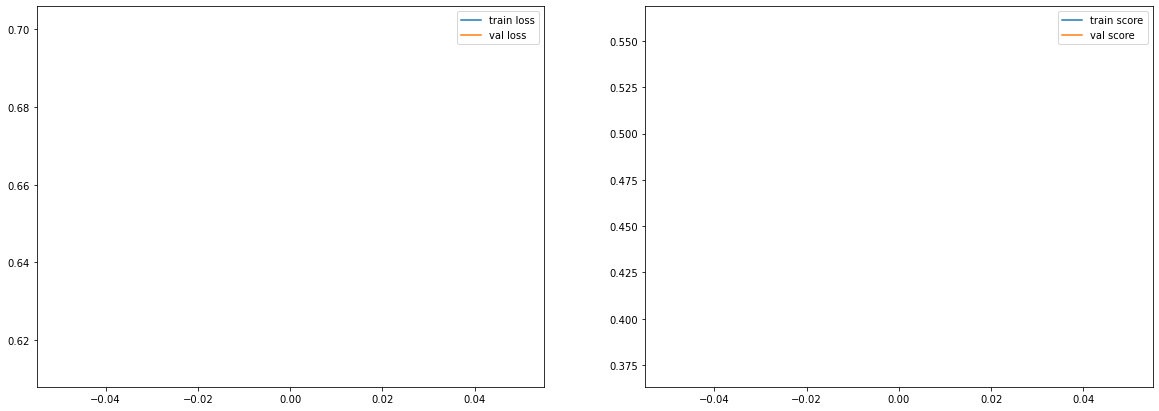


Epoch: 1
valid: 100%|██████████| 23/23 [00:04<00:00,  5.32it/s, dice_loss - 0.3665, iou_score - 0.7551]
Model saved!


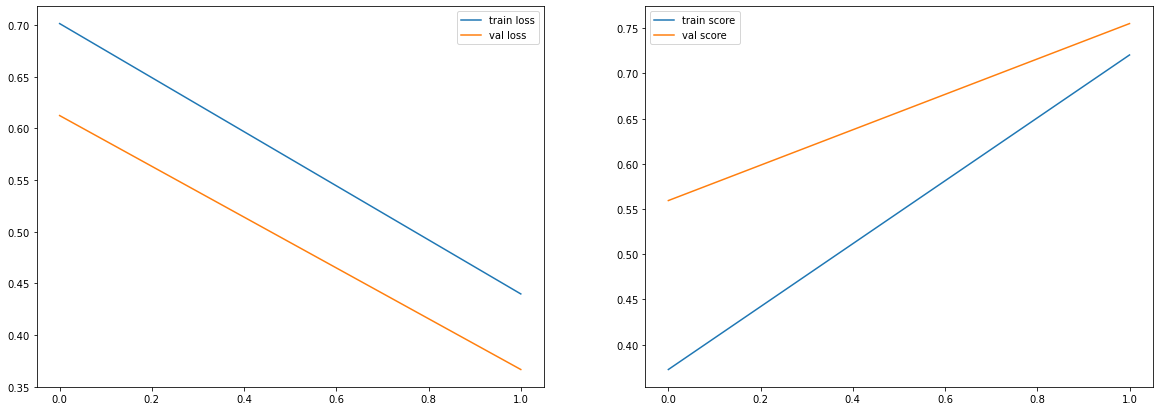


Epoch: 2
valid: 100%|██████████| 23/23 [00:05<00:00,  4.05it/s, dice_loss - 0.2428, iou_score - 0.8041]
Model saved!


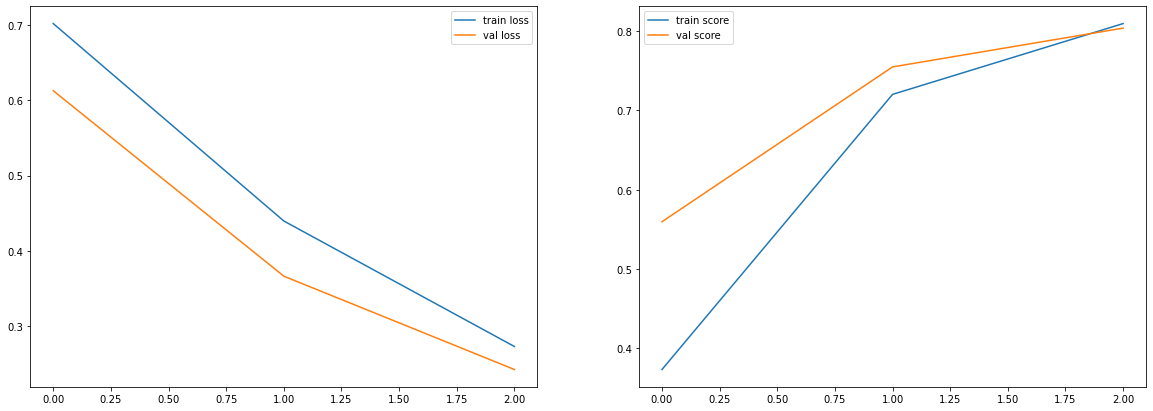


Epoch: 3
valid: 100%|██████████| 23/23 [00:04<00:00,  4.99it/s, dice_loss - 0.1921, iou_score - 0.8077]
Model saved!


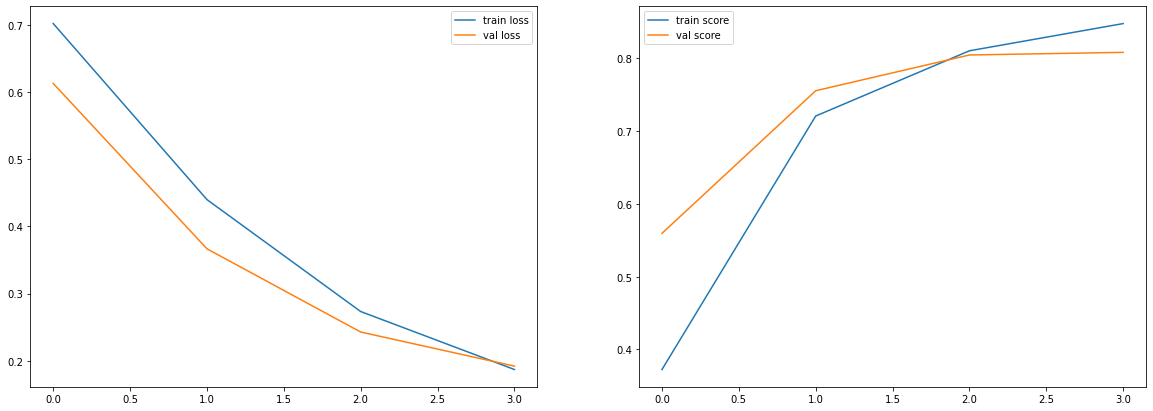


Epoch: 4
valid: 100%|██████████| 23/23 [00:04<00:00,  5.39it/s, dice_loss - 0.1566, iou_score - 0.8182]
Model saved!


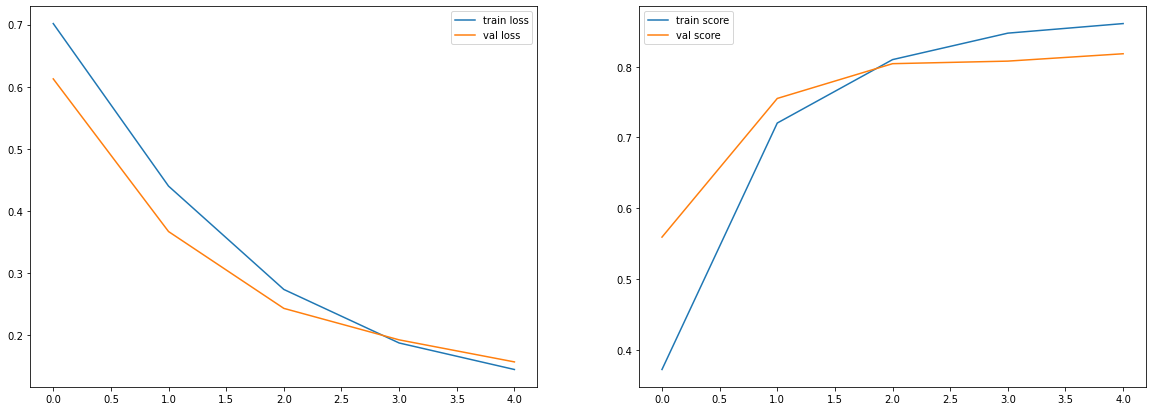


Epoch: 5
valid: 100%|██████████| 23/23 [00:04<00:00,  5.10it/s, dice_loss - 0.1436, iou_score - 0.814]
Model saved!


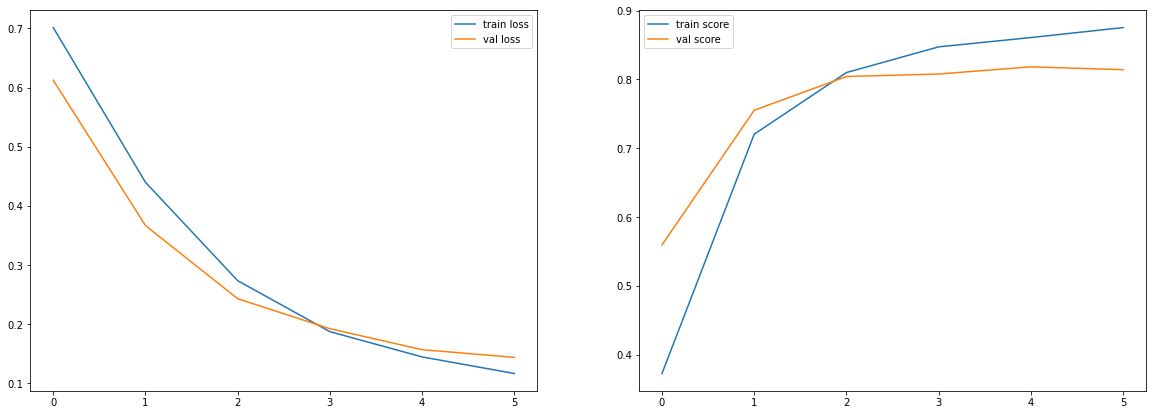


Epoch: 6
valid: 100%|██████████| 23/23 [00:04<00:00,  5.26it/s, dice_loss - 0.1335, iou_score - 0.8167]
Model saved!


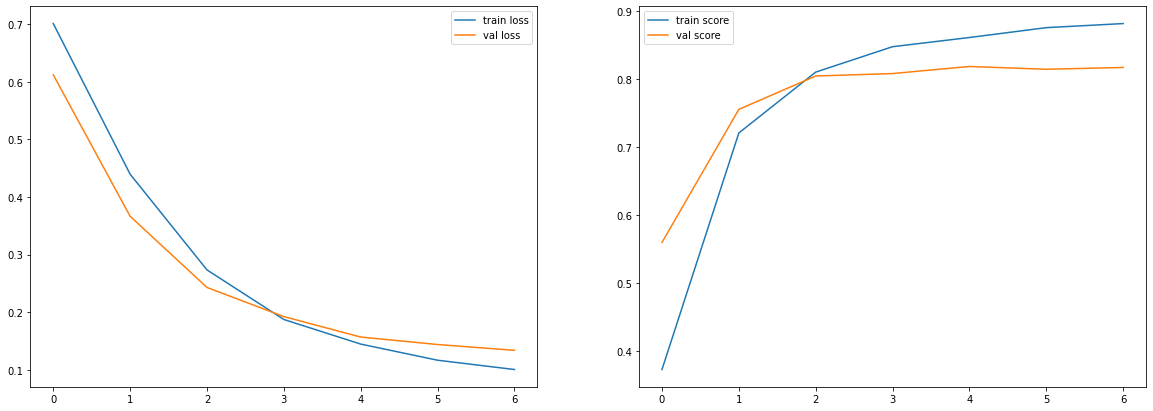


Epoch: 7
valid: 100%|██████████| 23/23 [00:04<00:00,  4.97it/s, dice_loss - 0.1238, iou_score - 0.8195]
Model saved!


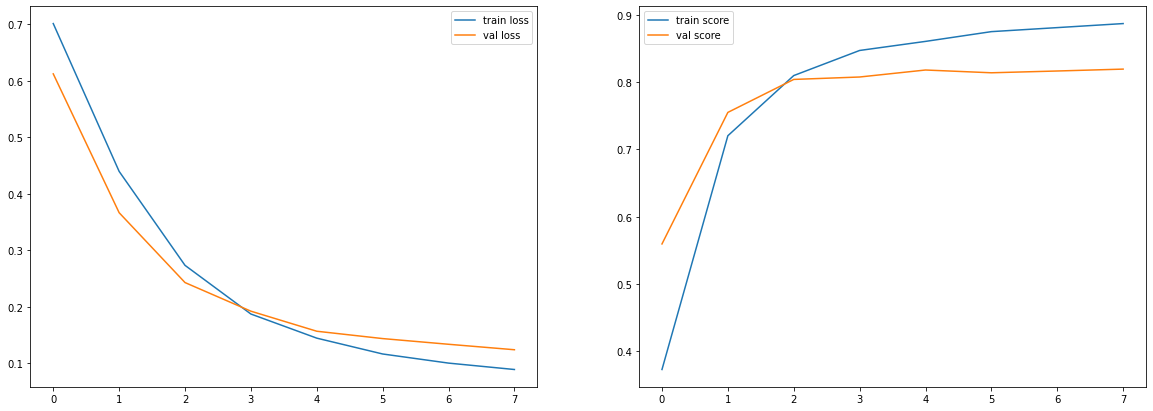


Epoch: 8
valid: 100%|██████████| 23/23 [00:04<00:00,  5.50it/s, dice_loss - 0.119, iou_score - 0.8213]
Model saved!


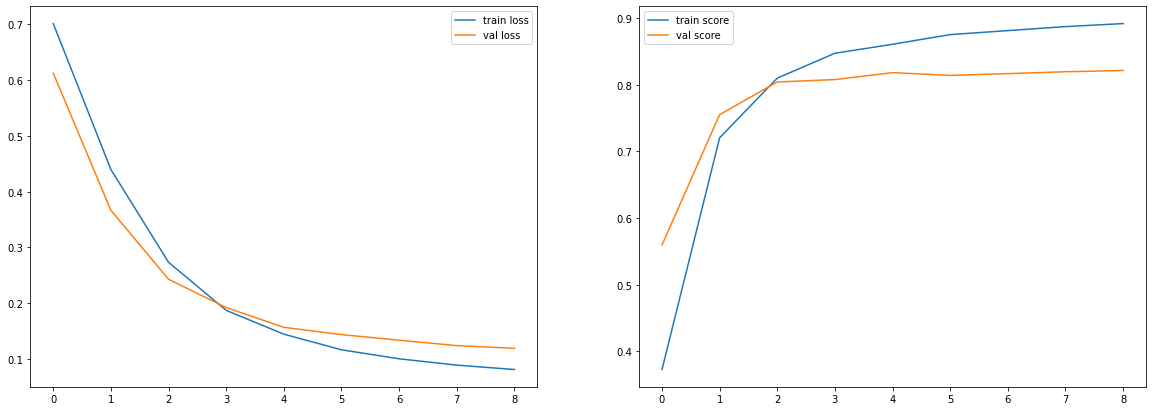


Epoch: 9
valid: 100%|██████████| 23/23 [00:04<00:00,  4.72it/s, dice_loss - 0.1134, iou_score - 0.8245]
Model saved!


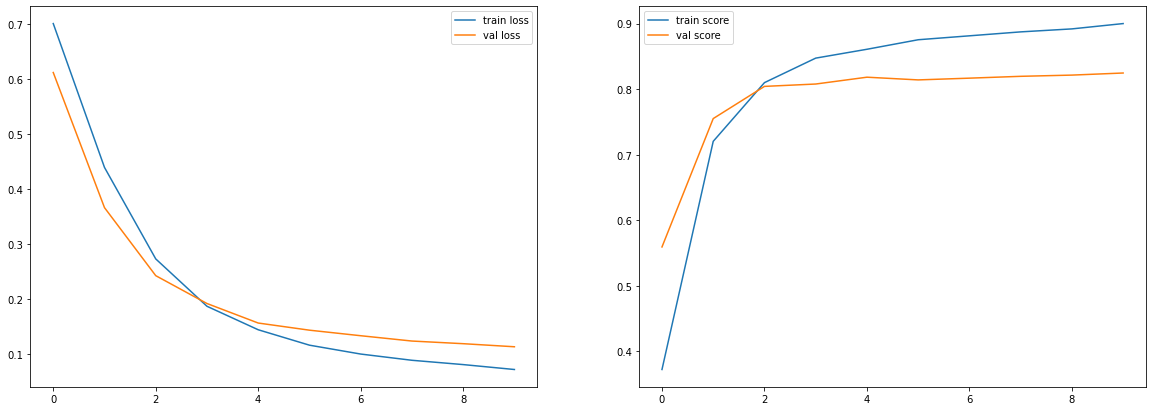


Epoch: 10
valid: 100%|██████████| 23/23 [00:04<00:00,  5.29it/s, dice_loss - 0.1103, iou_score - 0.8245]
Model saved!


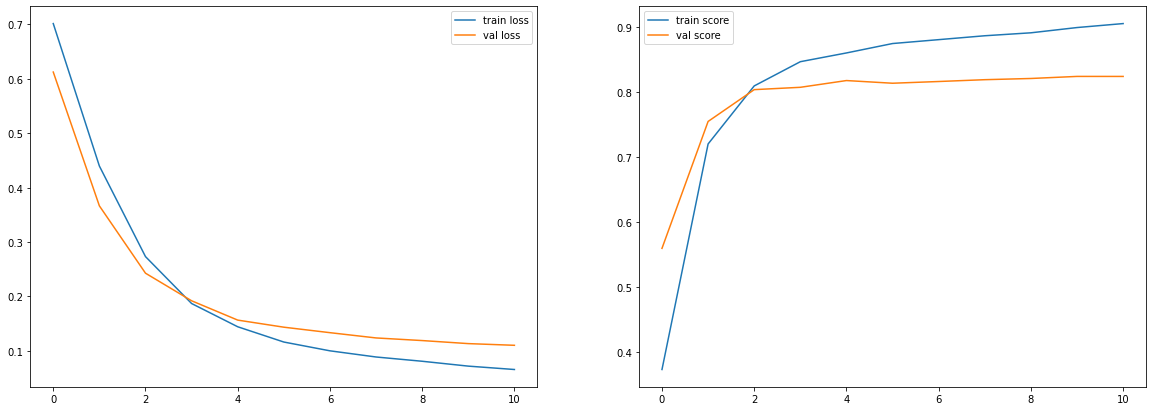


Epoch: 11
valid: 100%|██████████| 23/23 [00:04<00:00,  4.95it/s, dice_loss - 0.1079, iou_score - 0.8254]
Model saved!


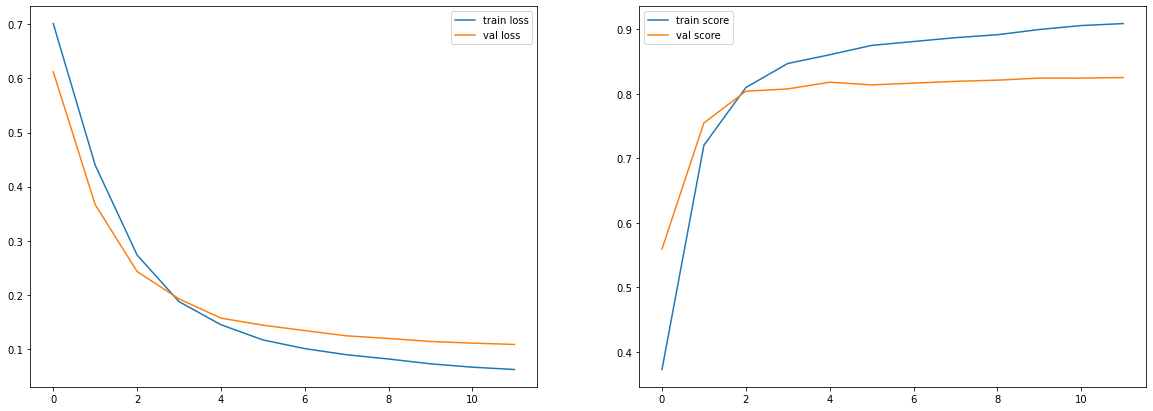


Epoch: 12
valid: 100%|██████████| 23/23 [00:05<00:00,  4.35it/s, dice_loss - 0.1065, iou_score - 0.8247]
Model saved!


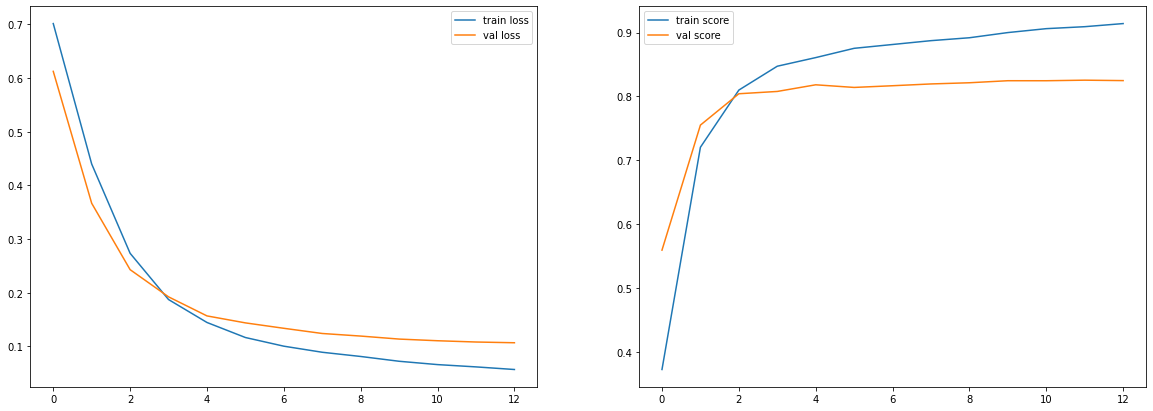


Epoch: 13
valid: 100%|██████████| 23/23 [00:04<00:00,  5.45it/s, dice_loss - 0.1064, iou_score - 0.8235]
Model saved!


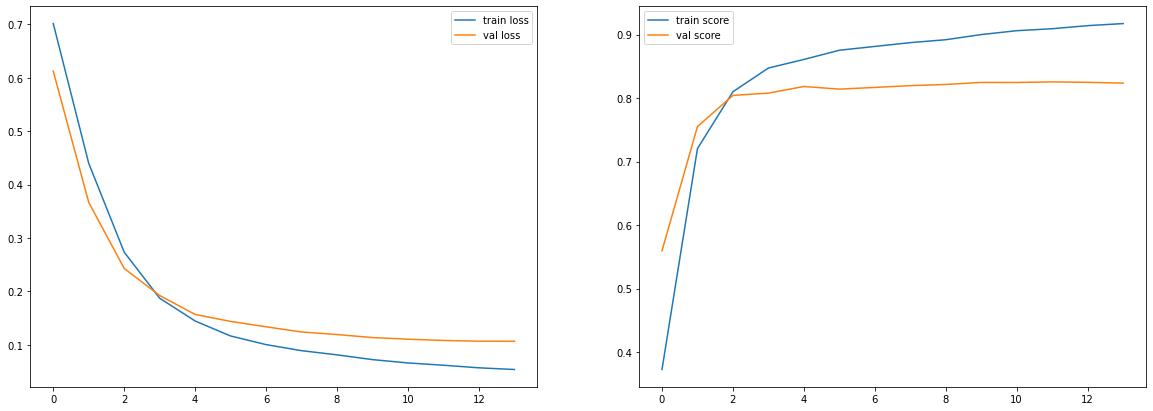


Epoch: 14
valid: 100%|██████████| 23/23 [00:04<00:00,  5.47it/s, dice_loss - 0.1036, iou_score - 0.8256]
Model saved!


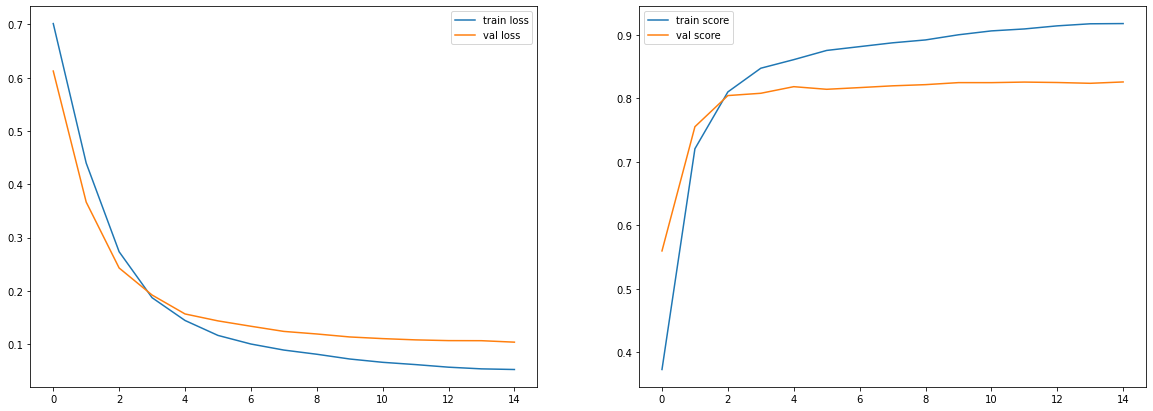


Epoch: 0
valid: 100%|██████████| 23/23 [00:05<00:00,  4.45it/s, dice_loss - 0.04379, iou_score - 0.9299]
Model saved!


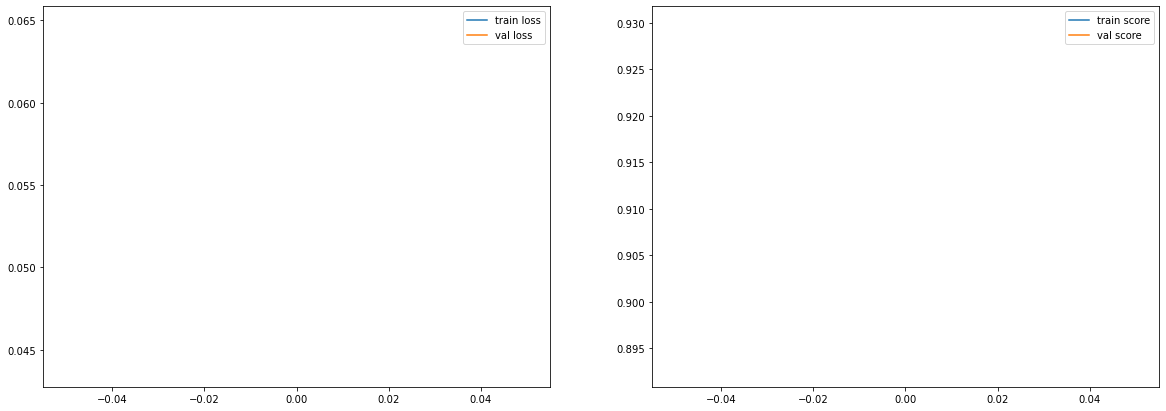


Epoch: 1
valid: 100%|██████████| 23/23 [00:04<00:00,  4.99it/s, dice_loss - 0.04269, iou_score - 0.931]
Model saved!


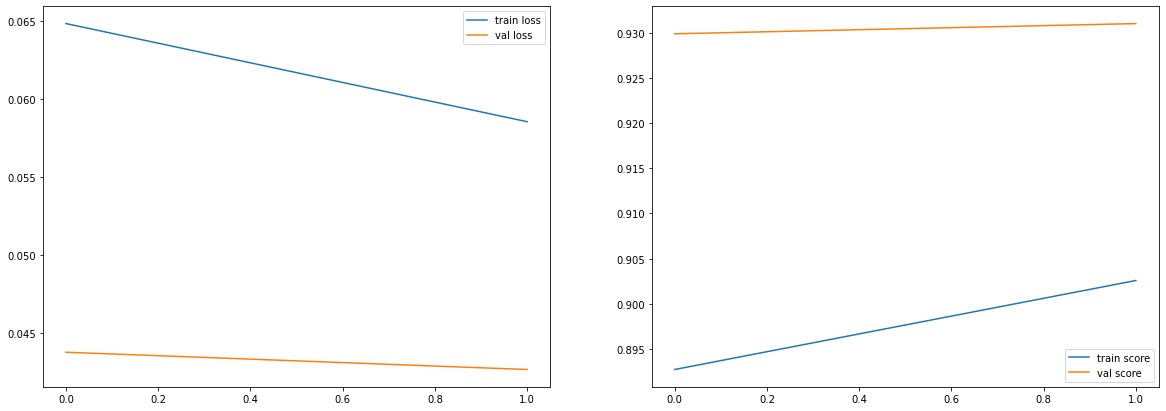


Epoch: 2
valid: 100%|██████████| 23/23 [00:05<00:00,  4.46it/s, dice_loss - 0.04397, iou_score - 0.927]


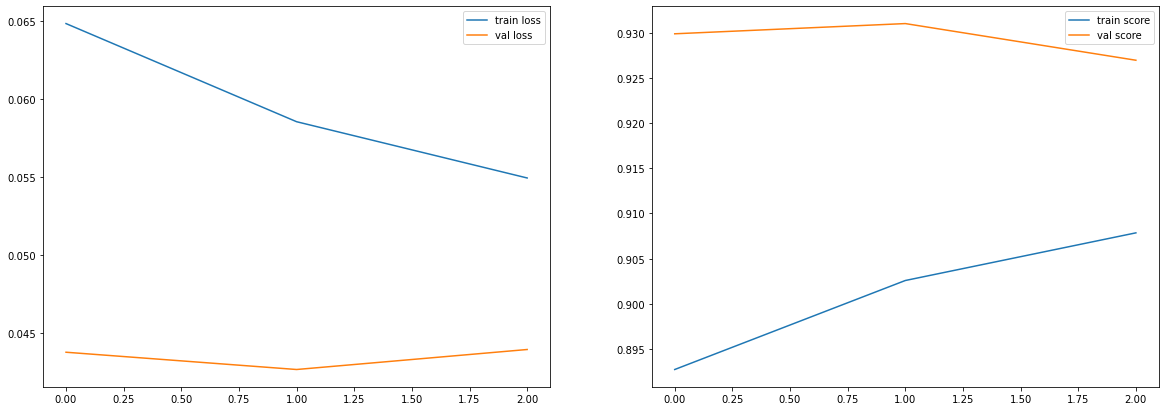


Epoch: 3
valid: 100%|██████████| 23/23 [00:04<00:00,  5.34it/s, dice_loss - 0.04511, iou_score - 0.9235]


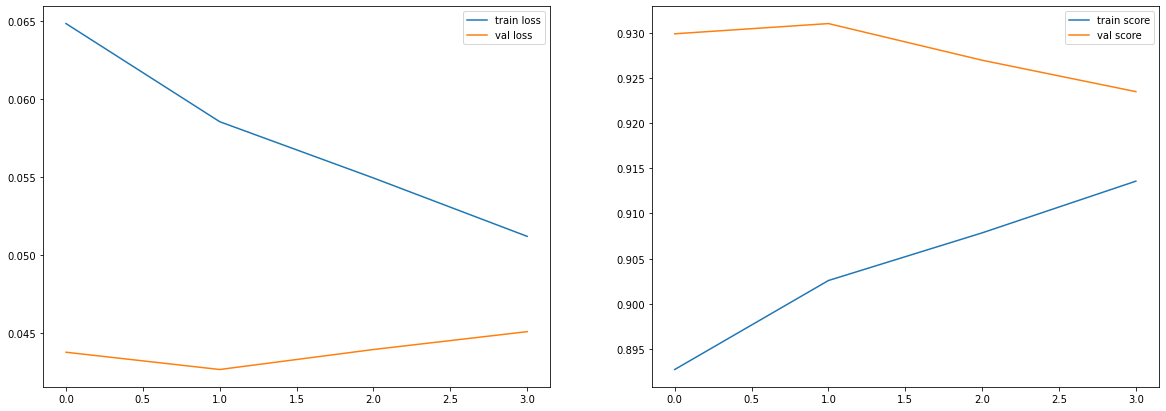


Epoch: 4
valid: 100%|██████████| 23/23 [00:04<00:00,  4.84it/s, dice_loss - 0.04452, iou_score - 0.9236]


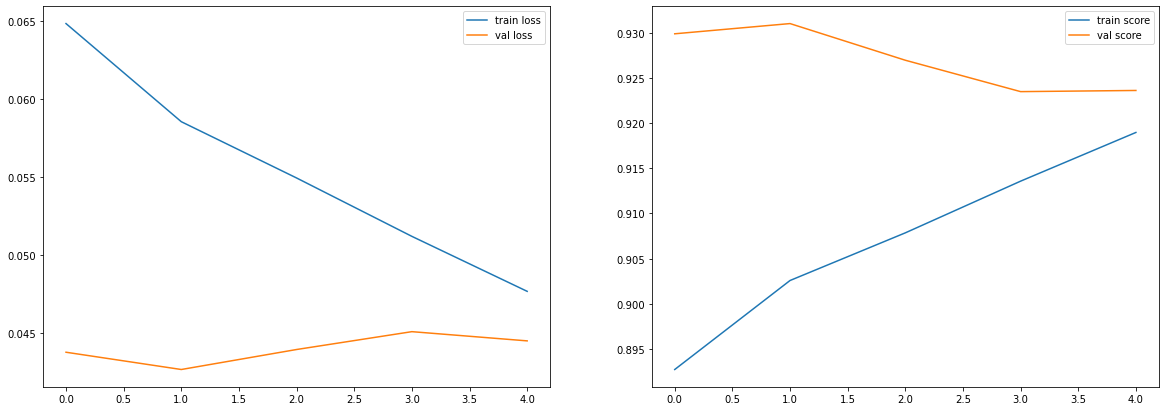


Epoch: 5
valid: 100%|██████████| 23/23 [00:04<00:00,  4.81it/s, dice_loss - 0.04425, iou_score - 0.9237]


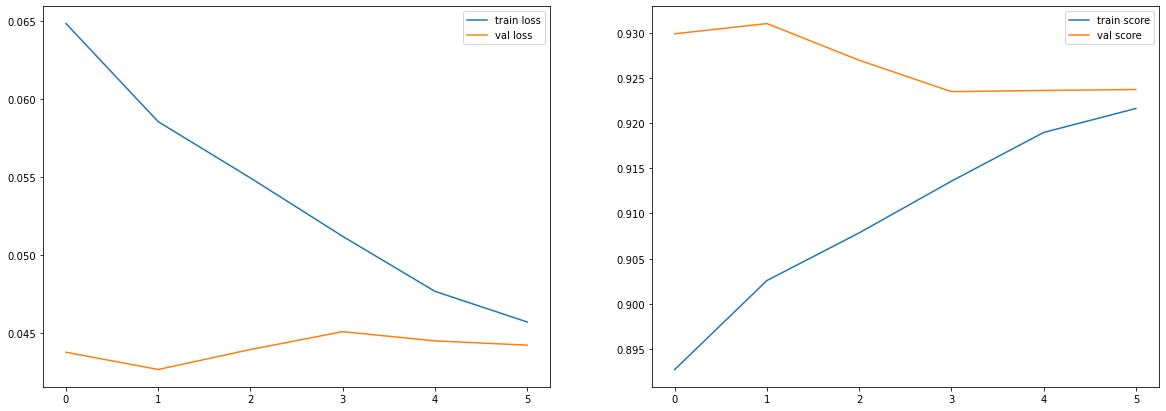


Epoch: 6
valid: 100%|██████████| 23/23 [00:04<00:00,  5.14it/s, dice_loss - 0.04206, iou_score - 0.9271]
Model saved!


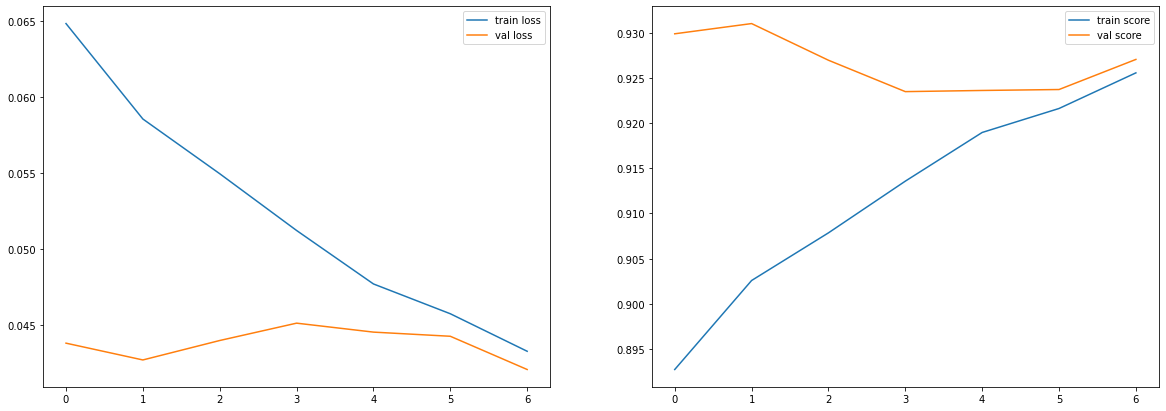


Epoch: 7
valid: 100%|██████████| 23/23 [00:04<00:00,  5.44it/s, dice_loss - 0.04236, iou_score - 0.9256]


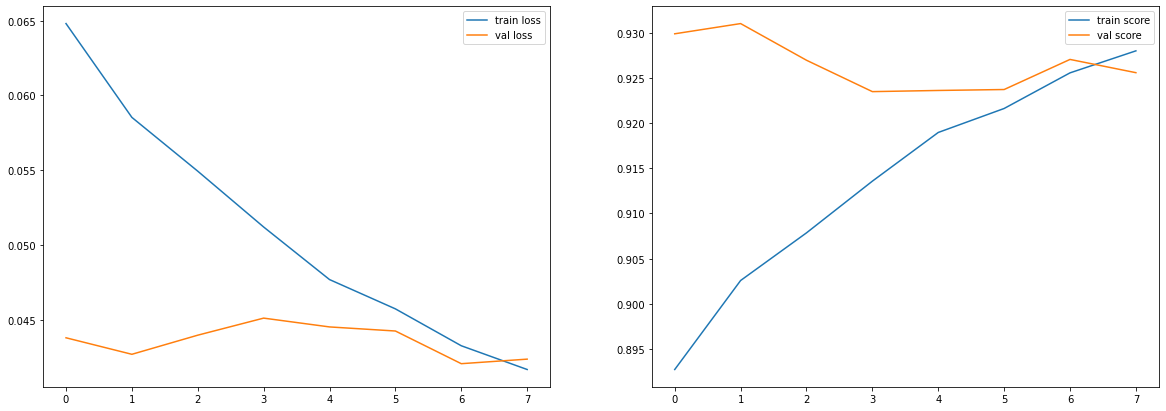


Epoch: 8
valid: 100%|██████████| 23/23 [00:04<00:00,  5.08it/s, dice_loss - 0.04173, iou_score - 0.9263]
Model saved!


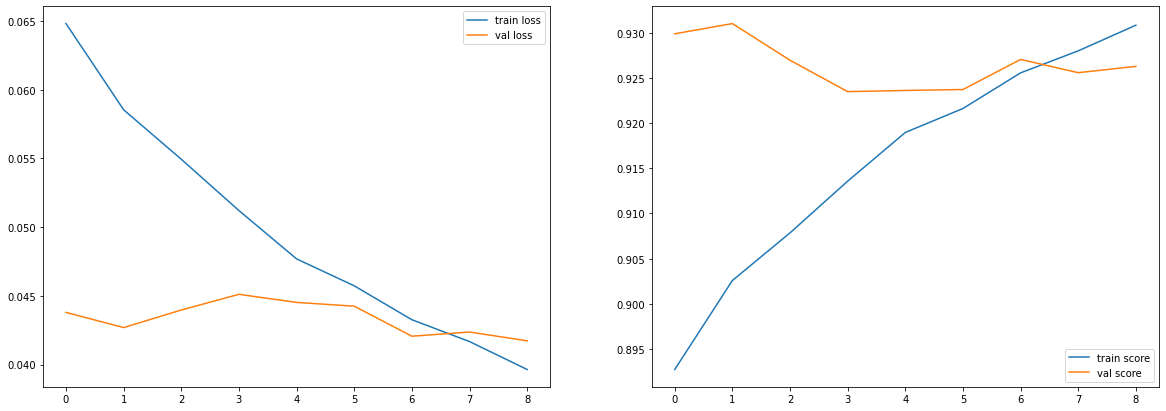


Epoch: 9
valid: 100%|██████████| 23/23 [00:04<00:00,  5.29it/s, dice_loss - 0.04056, iou_score - 0.9278]
Model saved!


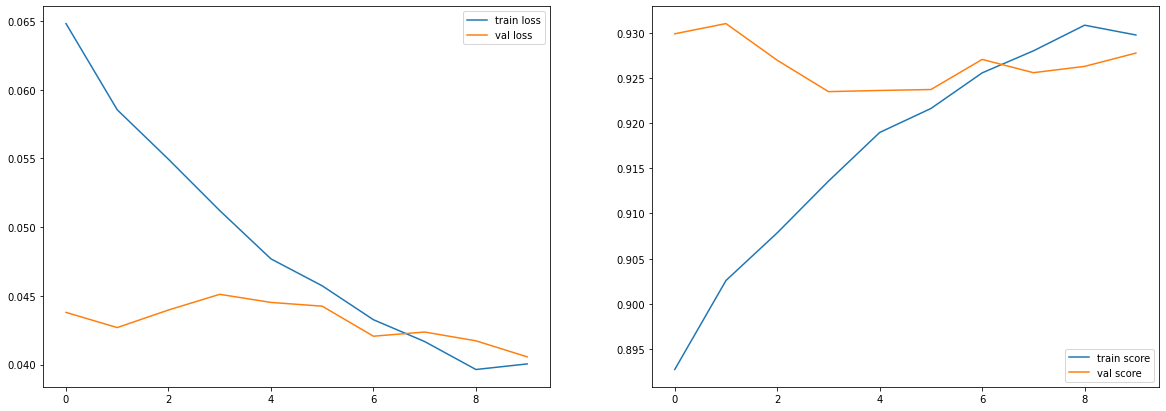


Epoch: 10
valid: 100%|██████████| 23/23 [00:05<00:00,  4.33it/s, dice_loss - 0.04438, iou_score - 0.9204]


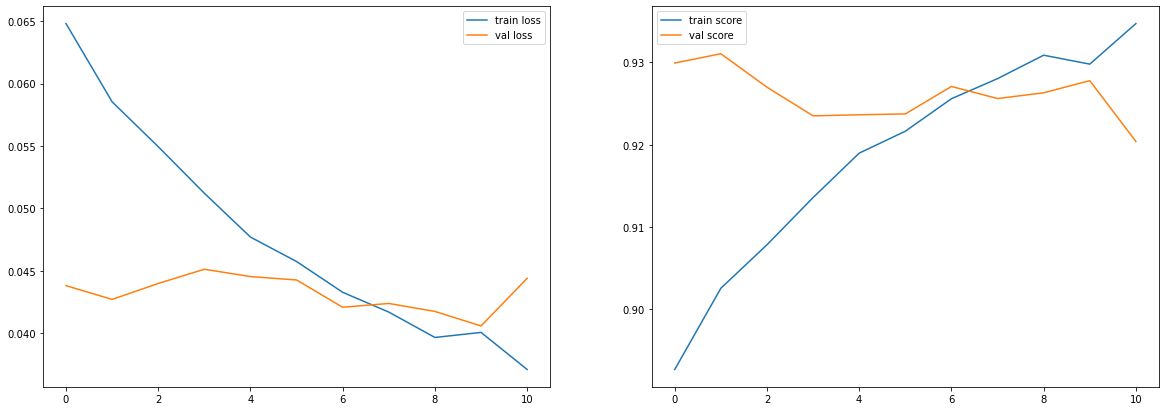


Epoch: 11
valid: 100%|██████████| 23/23 [00:04<00:00,  5.25it/s, dice_loss - 0.04188, iou_score - 0.9246]


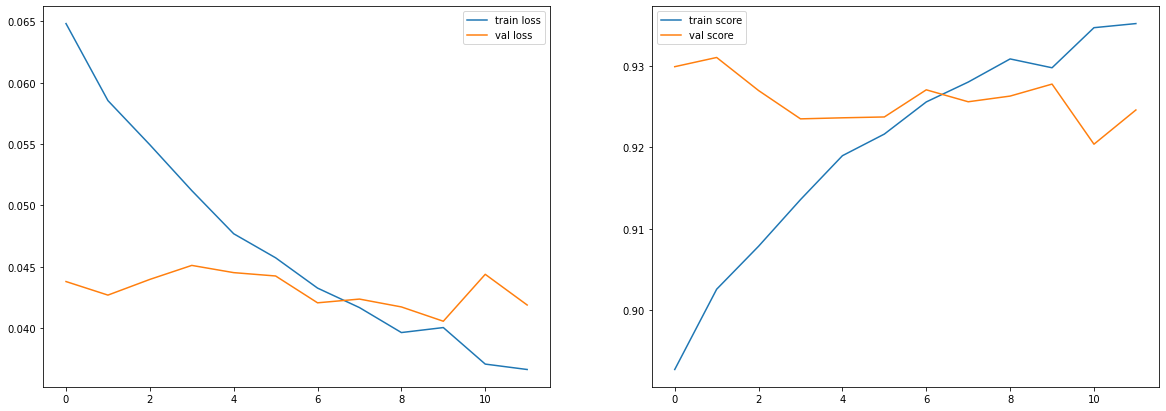


Epoch: 12
valid: 100%|██████████| 23/23 [00:04<00:00,  4.76it/s, dice_loss - 0.04106, iou_score - 0.9259]


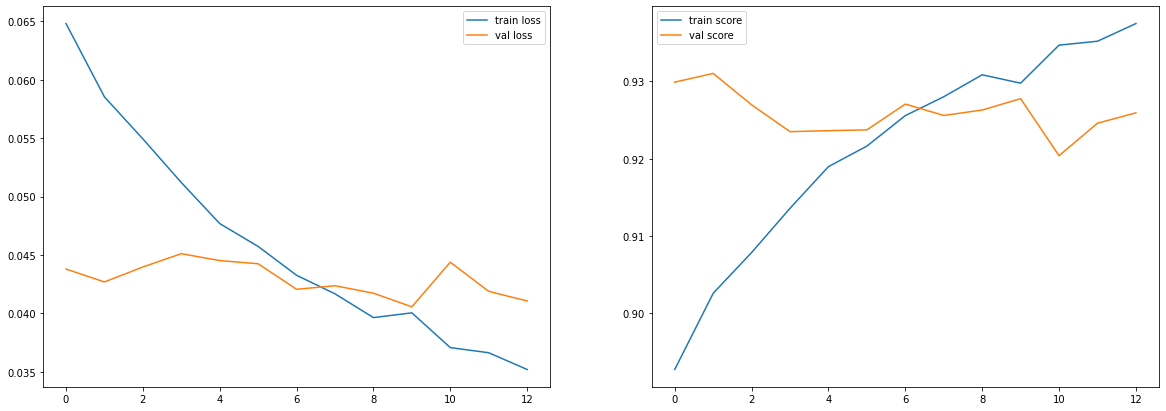


Epoch: 13
valid: 100%|██████████| 23/23 [00:05<00:00,  4.56it/s, dice_loss - 0.04085, iou_score - 0.9261]


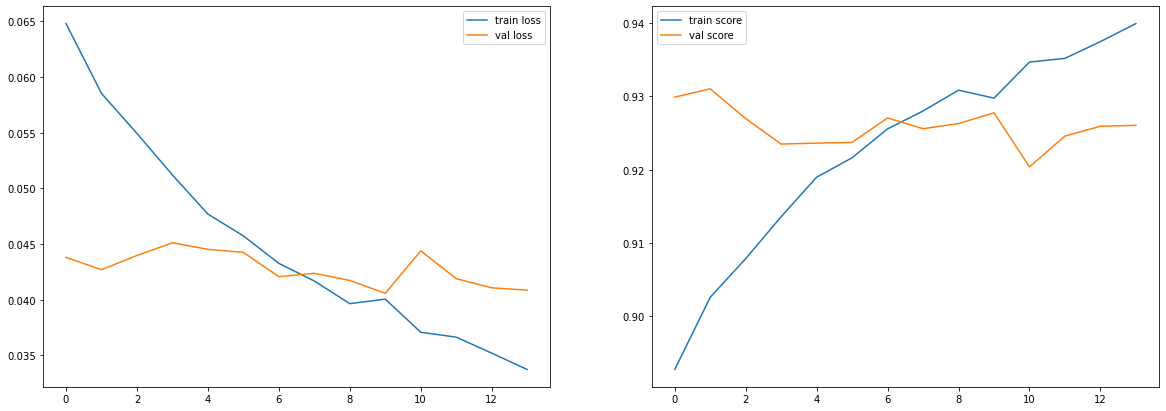


Epoch: 14
valid: 100%|██████████| 23/23 [00:04<00:00,  5.07it/s, dice_loss - 0.04144, iou_score - 0.9245]


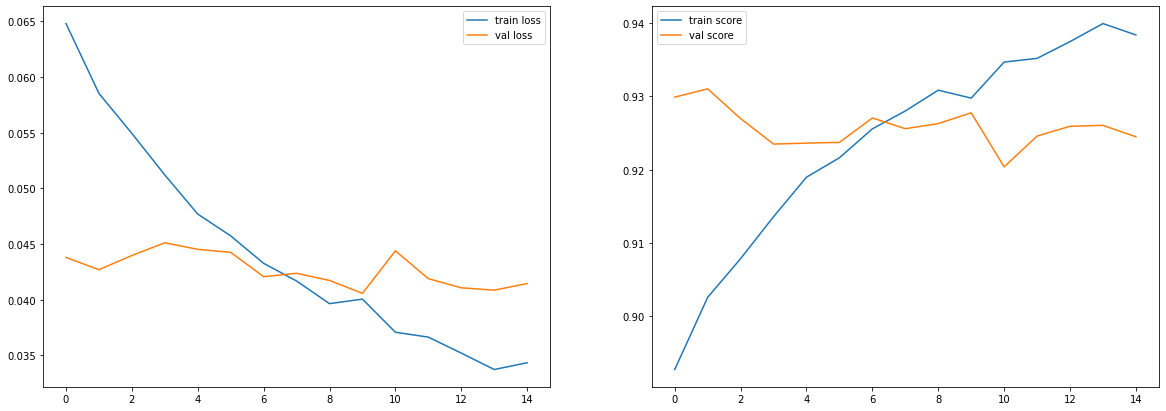


Epoch: 0
valid: 100%|██████████| 23/23 [00:04<00:00,  4.89it/s, dice_loss - 0.02778, iou_score - 0.9498]
Model saved!


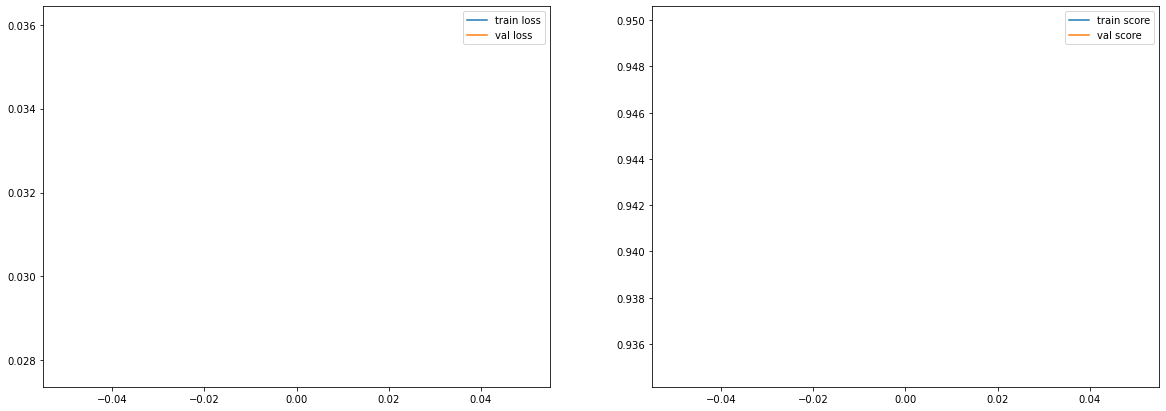


Epoch: 1
valid: 100%|██████████| 23/23 [00:04<00:00,  5.14it/s, dice_loss - 0.02723, iou_score - 0.9506]
Model saved!


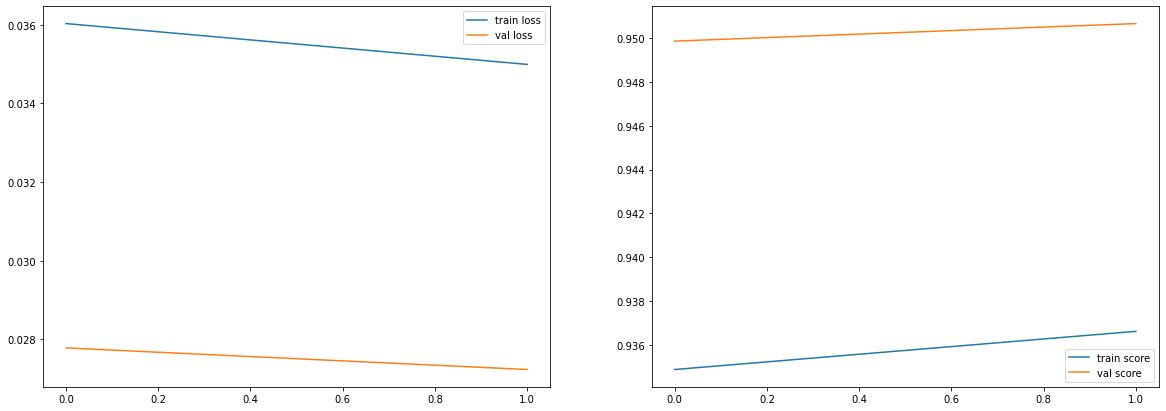


Epoch: 2
valid: 100%|██████████| 23/23 [00:04<00:00,  5.31it/s, dice_loss - 0.02839, iou_score - 0.9481]


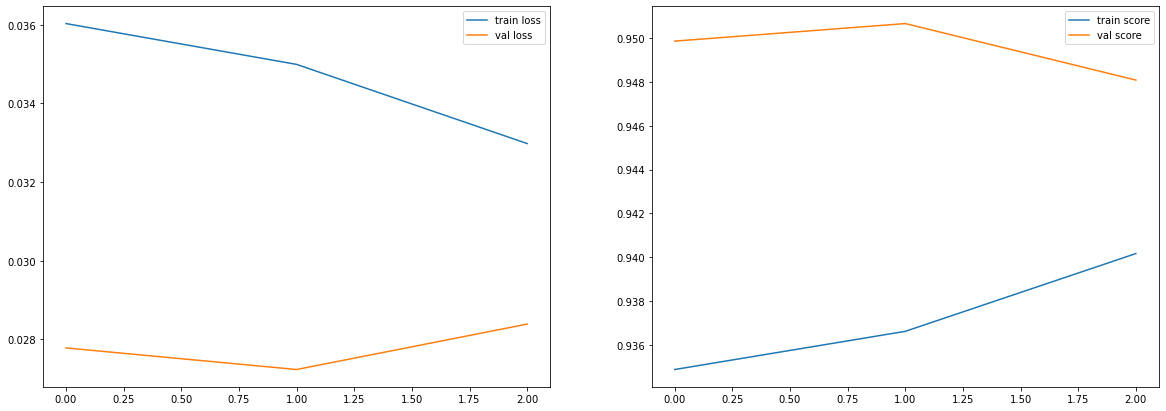


Epoch: 3
valid: 100%|██████████| 23/23 [00:04<00:00,  5.26it/s, dice_loss - 0.02698, iou_score - 0.9508]
Model saved!


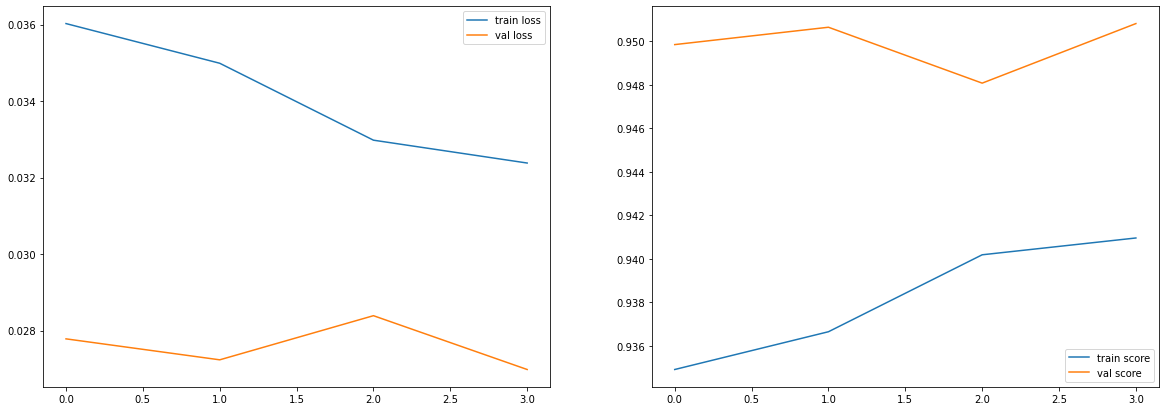


Epoch: 4
valid: 100%|██████████| 23/23 [00:05<00:00,  3.94it/s, dice_loss - 0.0276, iou_score - 0.9494]


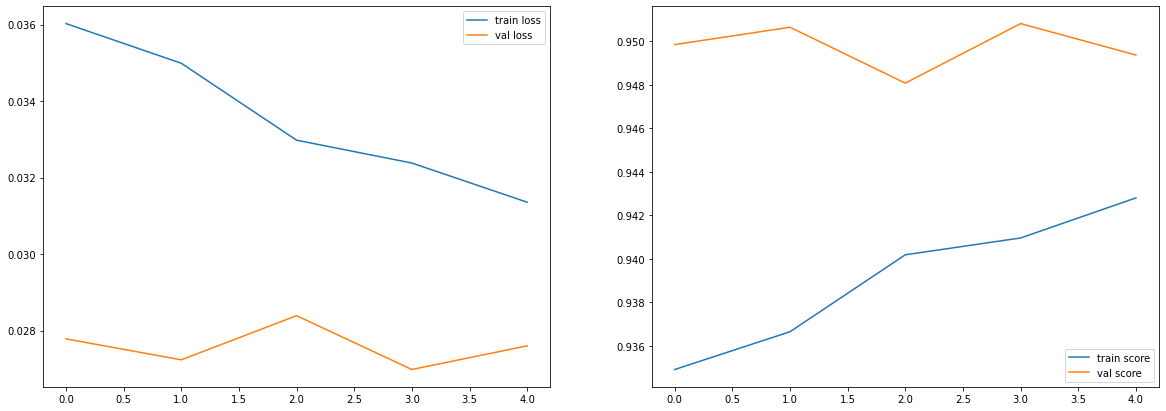


Epoch: 5
valid: 100%|██████████| 23/23 [00:04<00:00,  4.76it/s, dice_loss - 0.02606, iou_score - 0.9522]
Model saved!


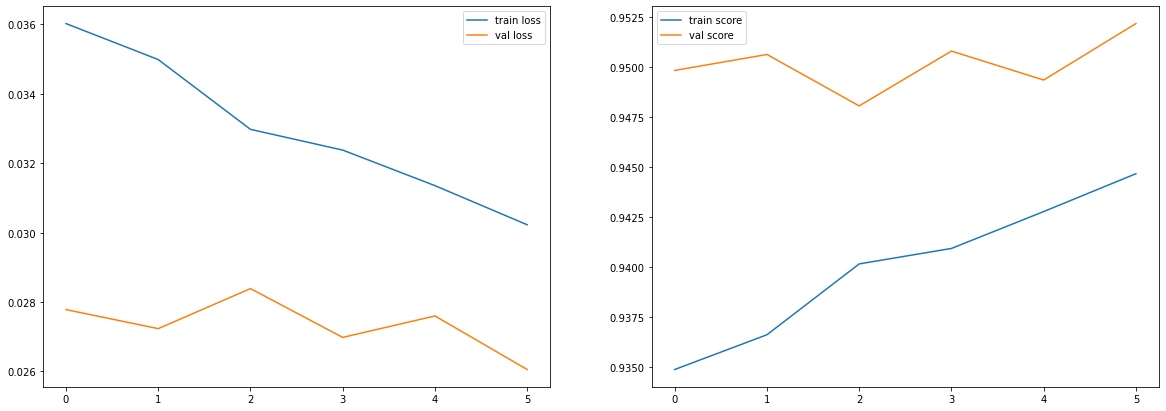


Epoch: 6
valid: 100%|██████████| 23/23 [00:04<00:00,  5.18it/s, dice_loss - 0.02616, iou_score - 0.9519]


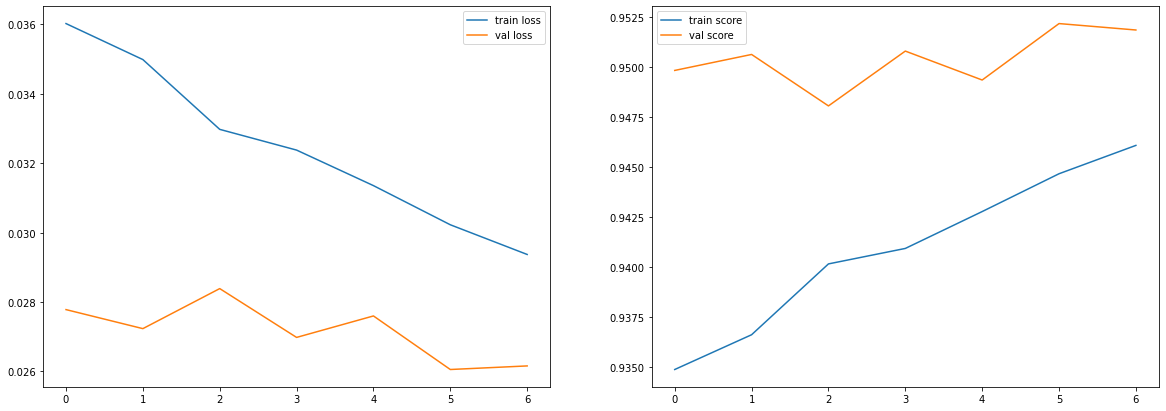


Epoch: 7
valid: 100%|██████████| 23/23 [00:04<00:00,  5.16it/s, dice_loss - 0.02638, iou_score - 0.9513]


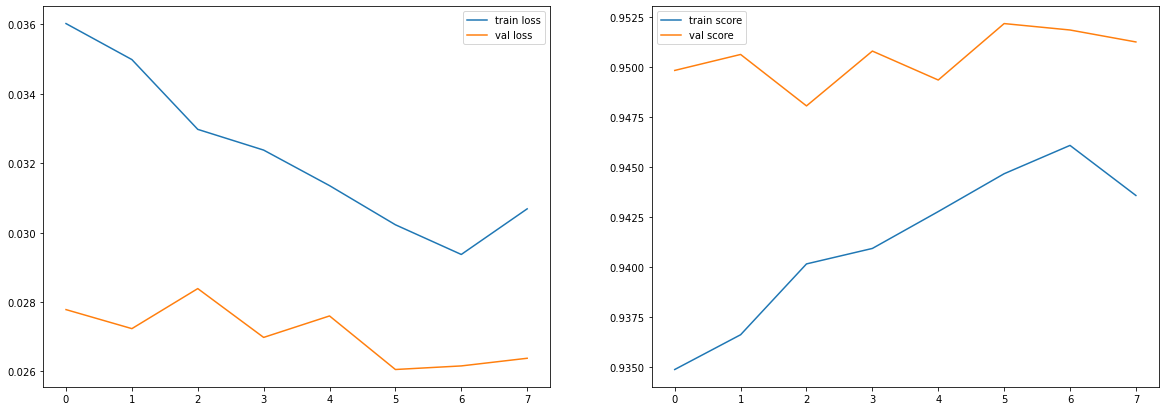


Epoch: 8
valid: 100%|██████████| 23/23 [00:04<00:00,  5.08it/s, dice_loss - 0.0269, iou_score - 0.95]


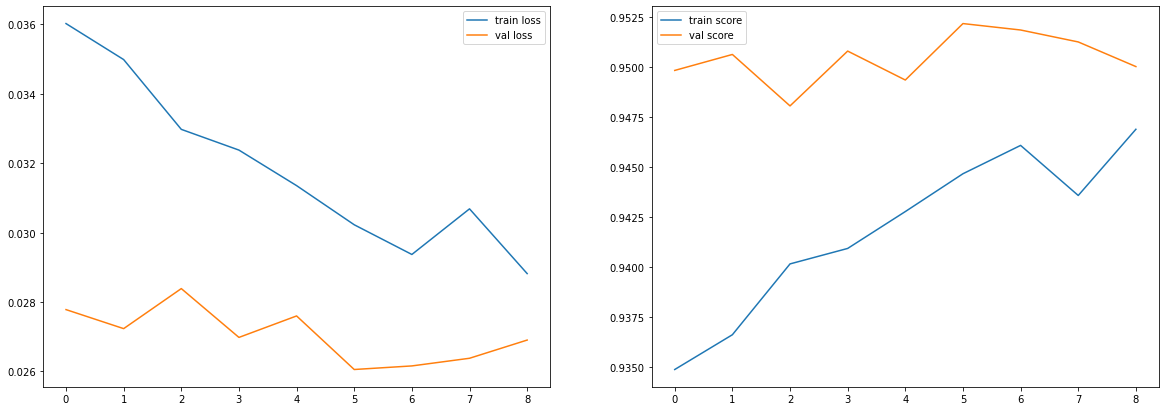


Epoch: 9
valid: 100%|██████████| 23/23 [00:04<00:00,  4.99it/s, dice_loss - 0.02801, iou_score - 0.9478]


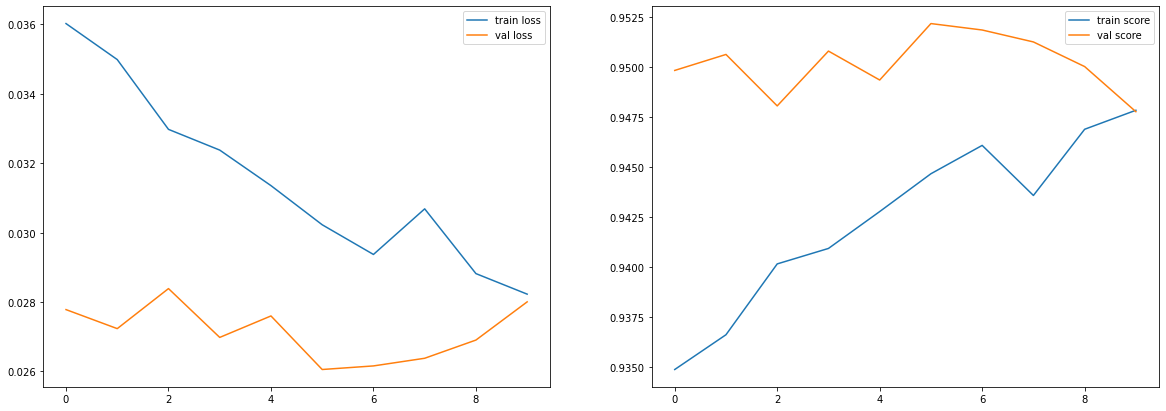


Epoch: 10
valid: 100%|██████████| 23/23 [00:05<00:00,  4.50it/s, dice_loss - 0.02629, iou_score - 0.9509]


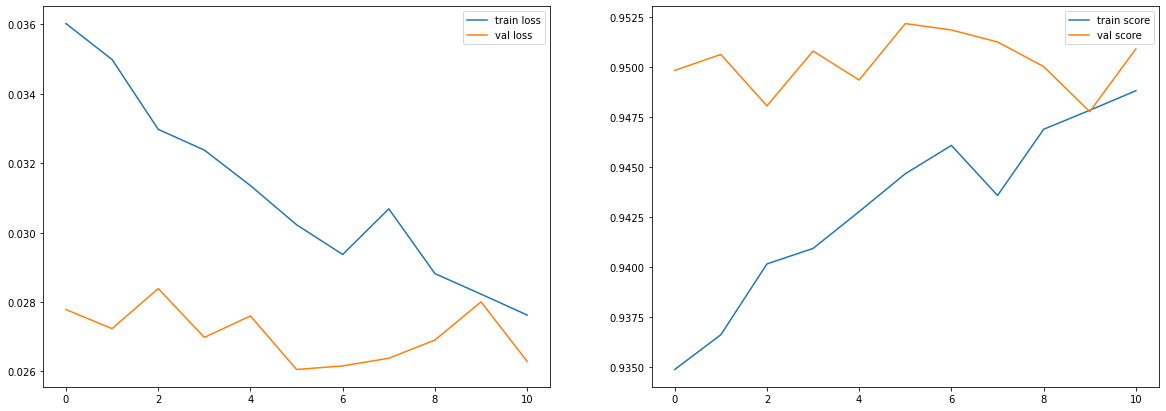


Epoch: 11
valid: 100%|██████████| 23/23 [00:05<00:00,  4.59it/s, dice_loss - 0.02697, iou_score - 0.9495]


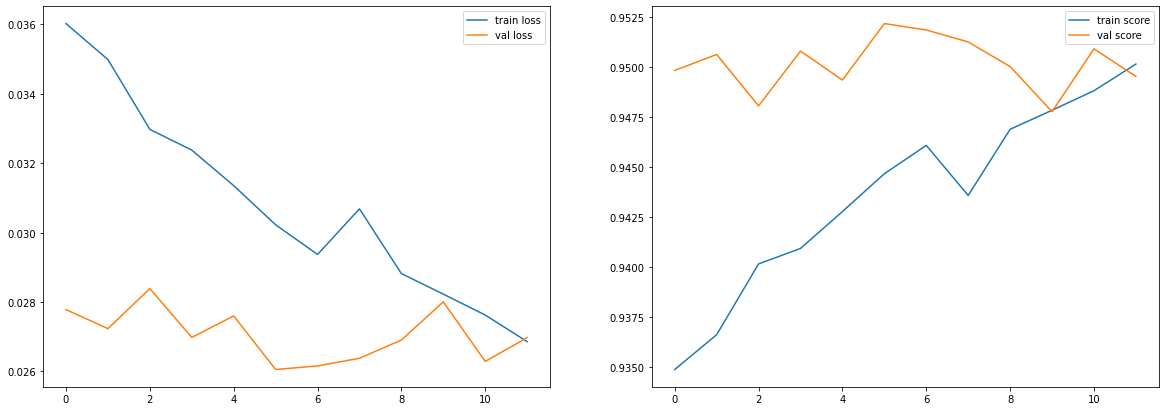


Epoch: 12
valid: 100%|██████████| 23/23 [00:04<00:00,  5.40it/s, dice_loss - 0.02783, iou_score - 0.9478]


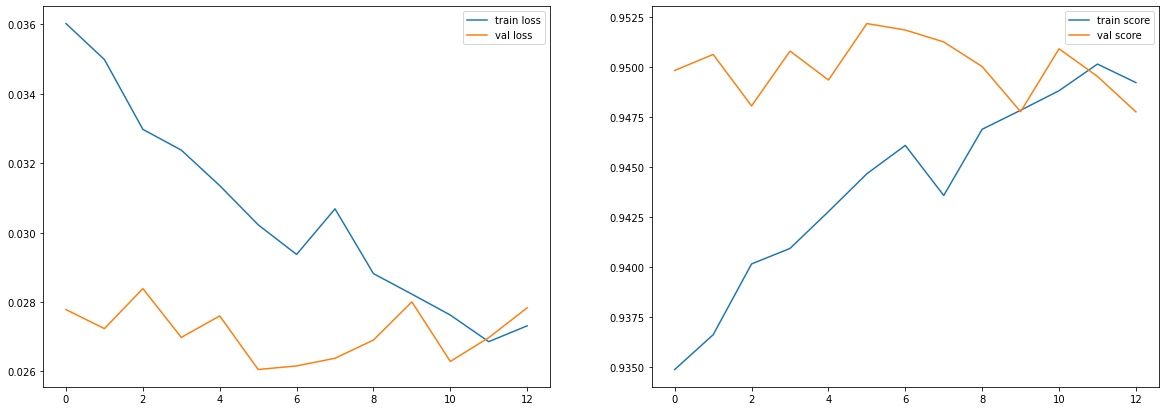


Epoch: 13
valid: 100%|██████████| 23/23 [00:04<00:00,  5.44it/s, dice_loss - 0.02682, iou_score - 0.9497]


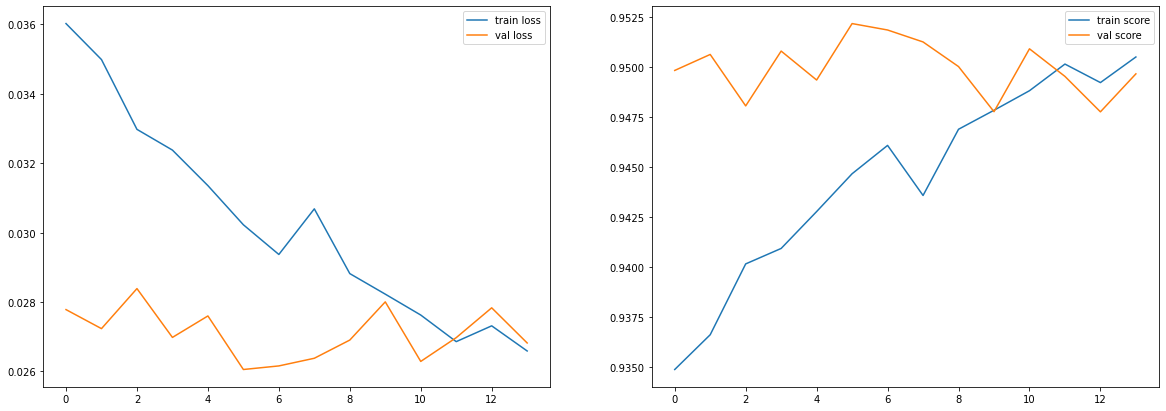


Epoch: 14
valid: 100%|██████████| 23/23 [00:04<00:00,  4.96it/s, dice_loss - 0.02683, iou_score - 0.9495]


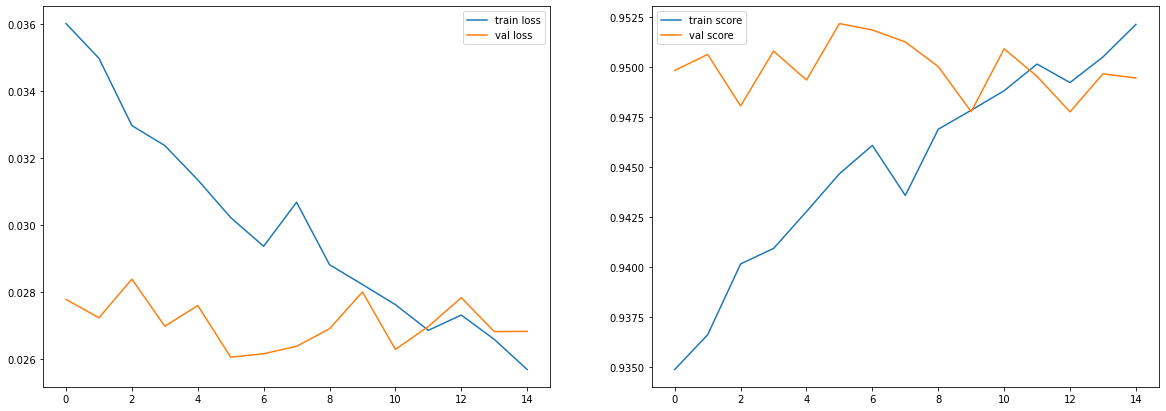


Epoch: 0
valid: 100%|██████████| 23/23 [00:05<00:00,  4.37it/s, dice_loss - 0.06512, iou_score - 0.9161]
Model saved!


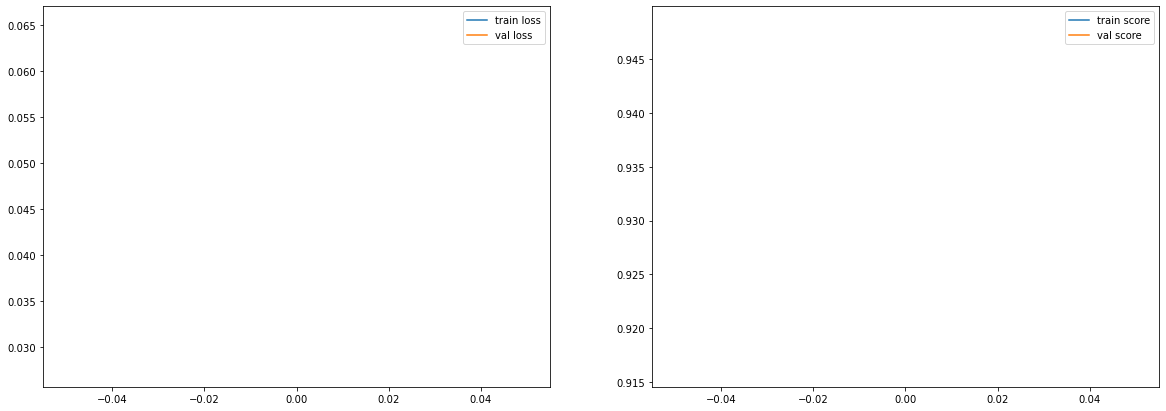


Epoch: 1
valid: 100%|██████████| 23/23 [00:04<00:00,  5.38it/s, dice_loss - 0.06467, iou_score - 0.9169]
Model saved!


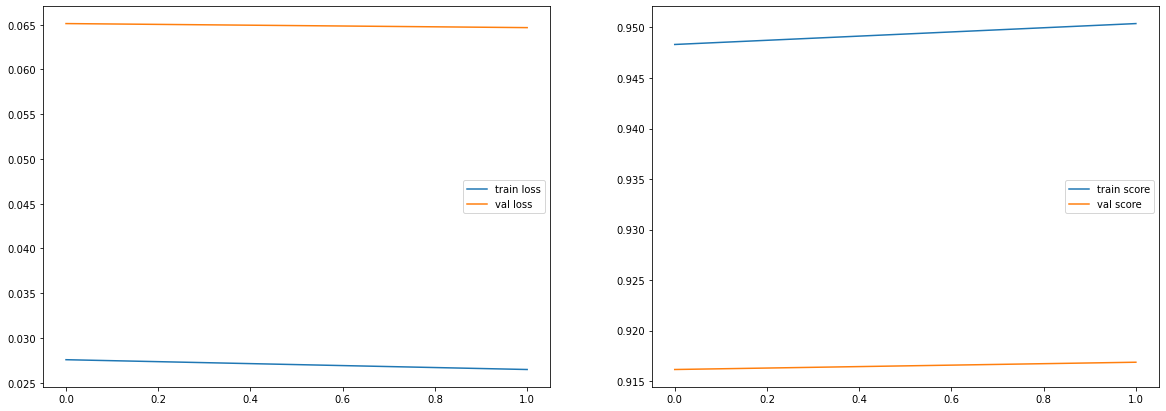


Epoch: 2
valid: 100%|██████████| 23/23 [00:04<00:00,  5.41it/s, dice_loss - 0.06422, iou_score - 0.9176]
Model saved!


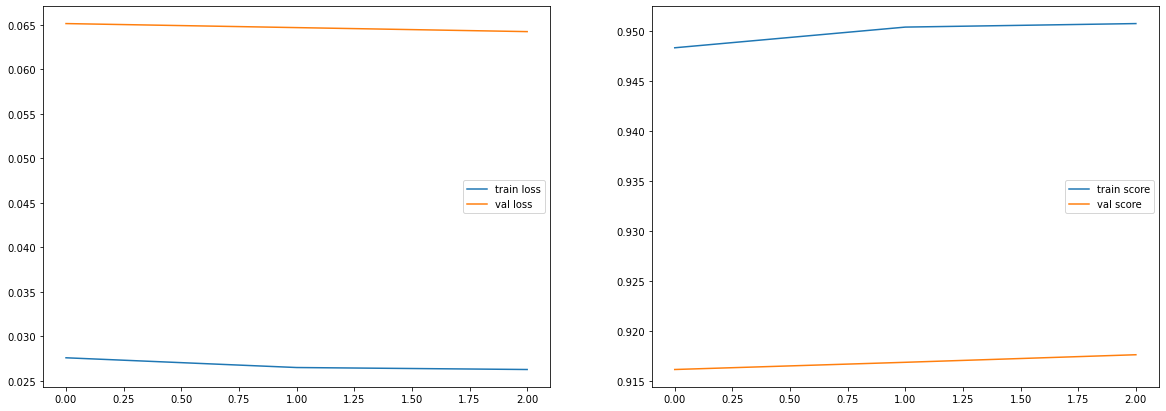


Epoch: 3
valid: 100%|██████████| 23/23 [00:05<00:00,  3.98it/s, dice_loss - 0.06429, iou_score - 0.9175]


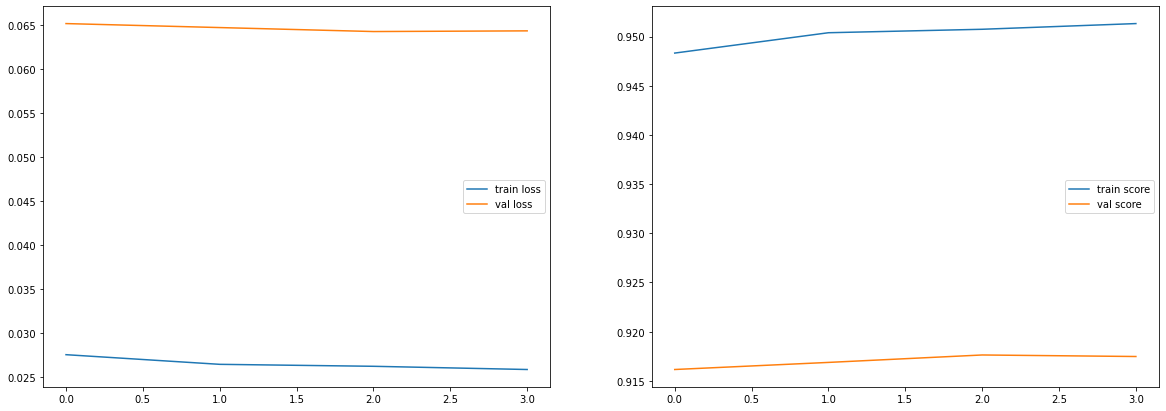


Epoch: 4
valid: 100%|██████████| 23/23 [00:04<00:00,  4.86it/s, dice_loss - 0.06364, iou_score - 0.9187]
Model saved!


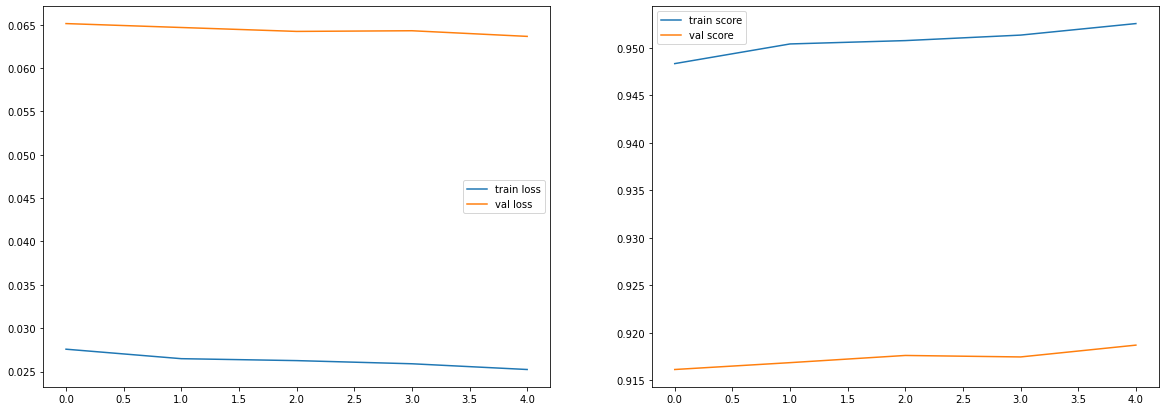


Epoch: 5
valid: 100%|██████████| 23/23 [00:04<00:00,  5.24it/s, dice_loss - 0.06388, iou_score - 0.9181]


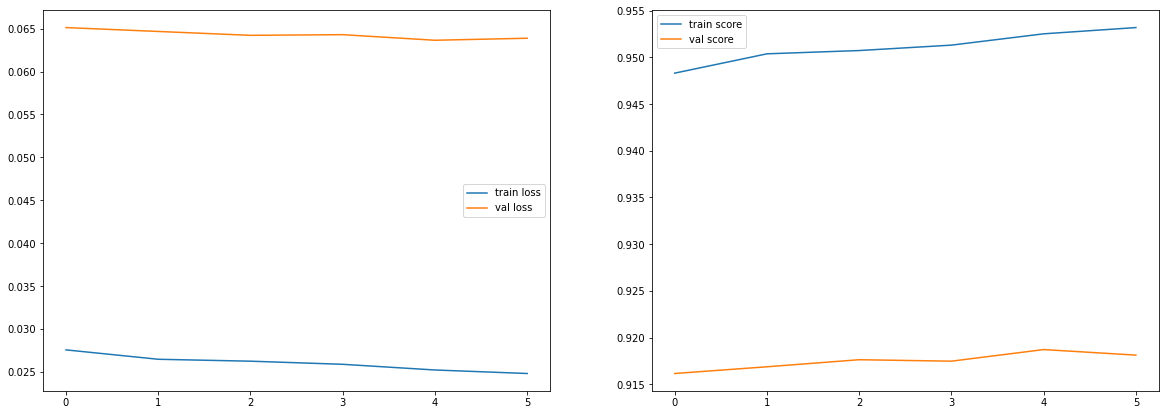


Epoch: 6
valid: 100%|██████████| 23/23 [00:04<00:00,  4.91it/s, dice_loss - 0.06362, iou_score - 0.9186]
Model saved!


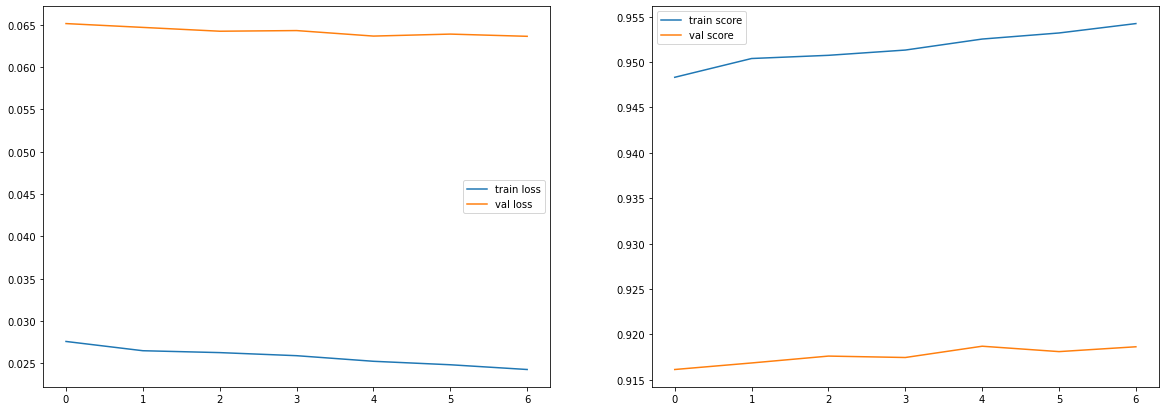


Epoch: 7
valid: 100%|██████████| 23/23 [00:04<00:00,  5.44it/s, dice_loss - 0.06572, iou_score - 0.9144]


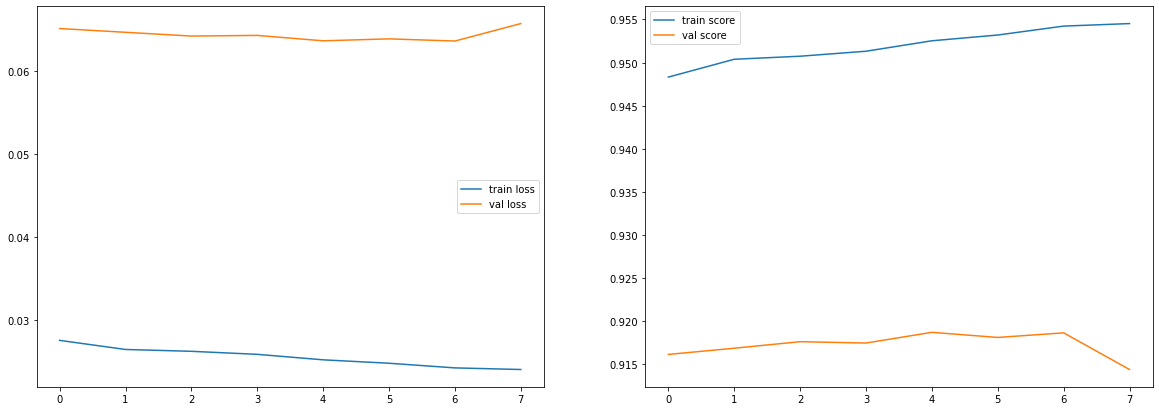


Epoch: 8
valid: 100%|██████████| 23/23 [00:04<00:00,  4.73it/s, dice_loss - 0.06354, iou_score - 0.9186]
Model saved!


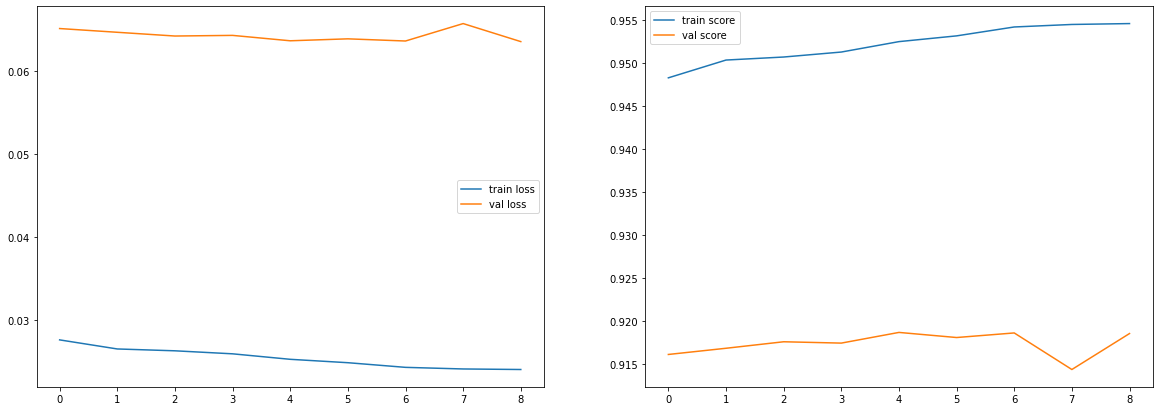


Epoch: 9
valid: 100%|██████████| 23/23 [00:04<00:00,  4.87it/s, dice_loss - 0.06485, iou_score - 0.9159]


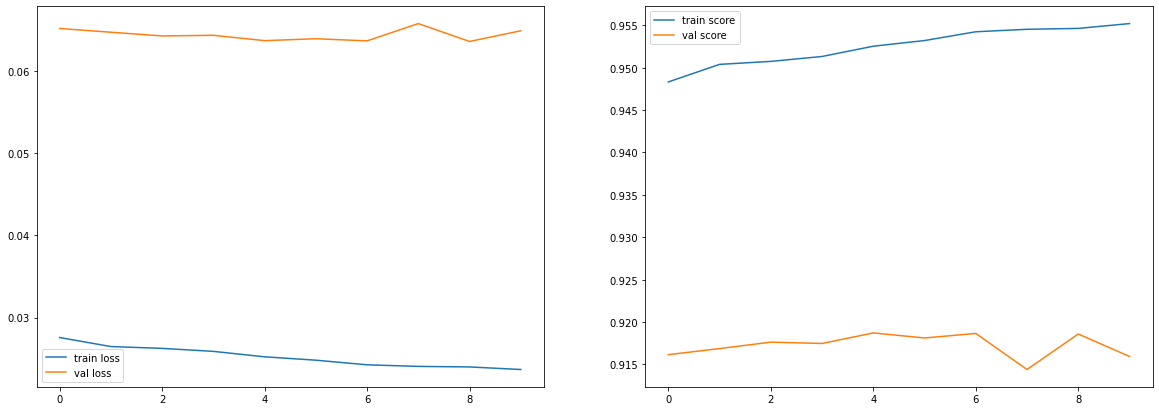


Epoch: 10
valid: 100%|██████████| 23/23 [00:04<00:00,  5.42it/s, dice_loss - 0.06422, iou_score - 0.9172]


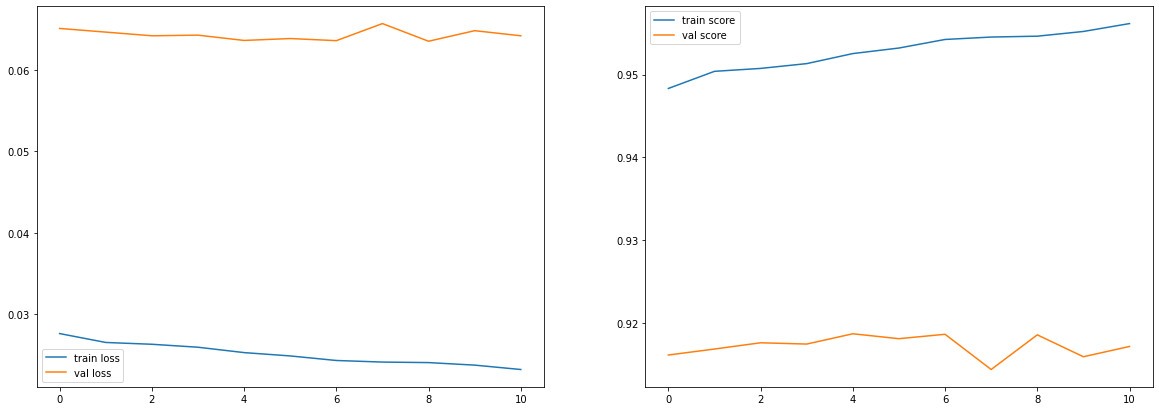


Epoch: 11
valid: 100%|██████████| 23/23 [00:04<00:00,  4.84it/s, dice_loss - 0.06385, iou_score - 0.9179]


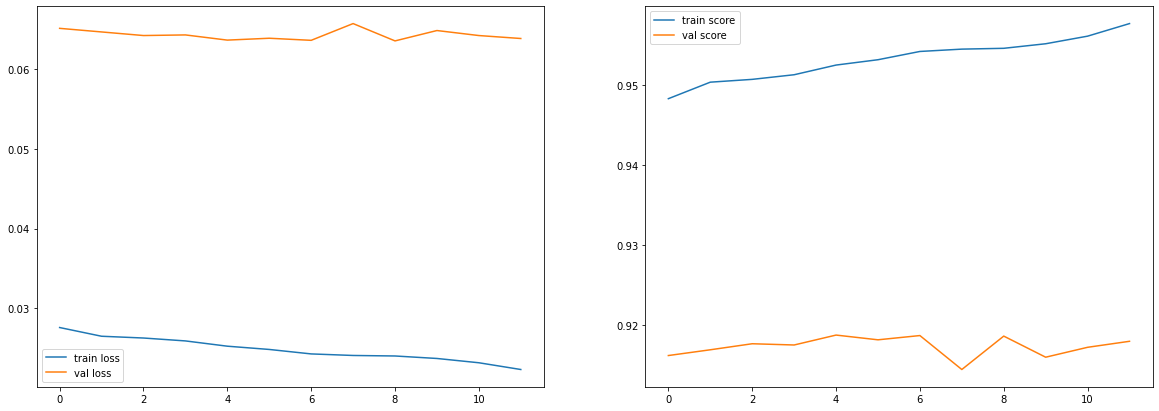


Epoch: 12
valid: 100%|██████████| 23/23 [00:04<00:00,  5.32it/s, dice_loss - 0.06404, iou_score - 0.9175]


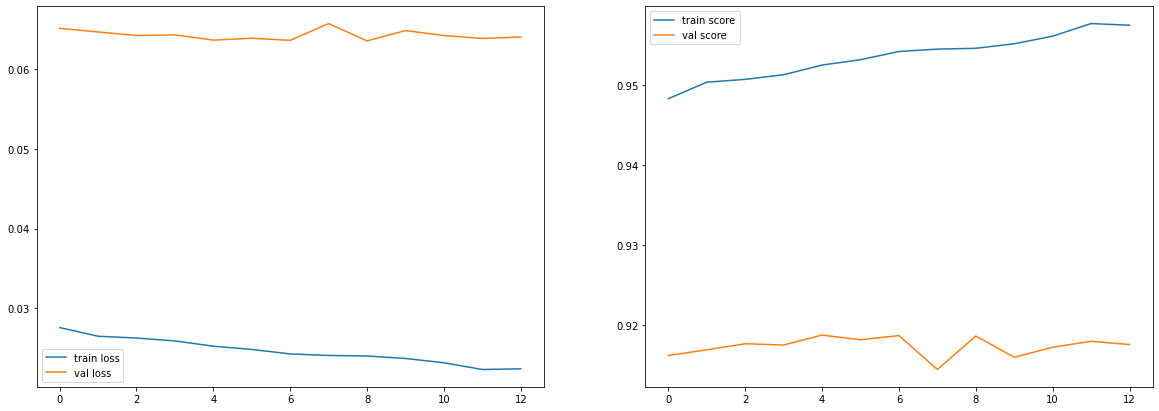


Epoch: 13
valid: 100%|██████████| 23/23 [00:05<00:00,  4.46it/s, dice_loss - 0.0706, iou_score - 0.9052]


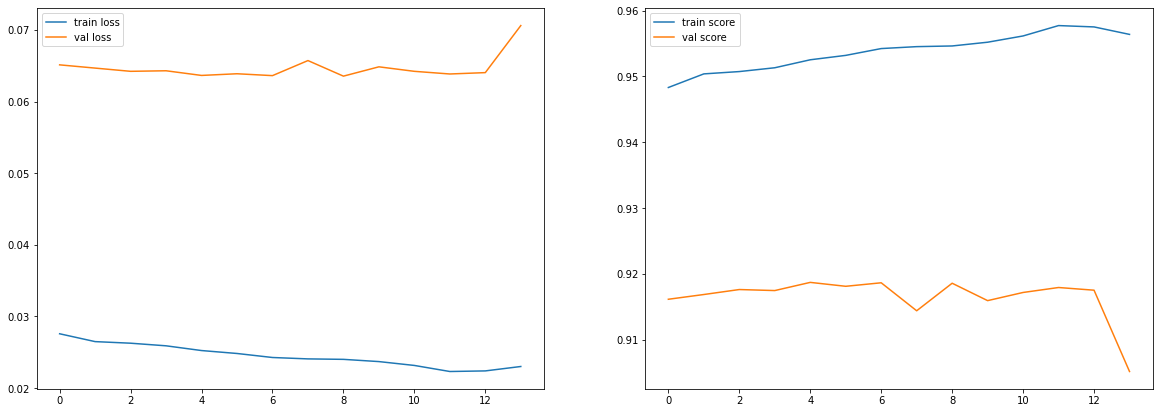


Epoch: 14
valid: 100%|██████████| 23/23 [00:04<00:00,  5.03it/s, dice_loss - 0.06541, iou_score - 0.9147]


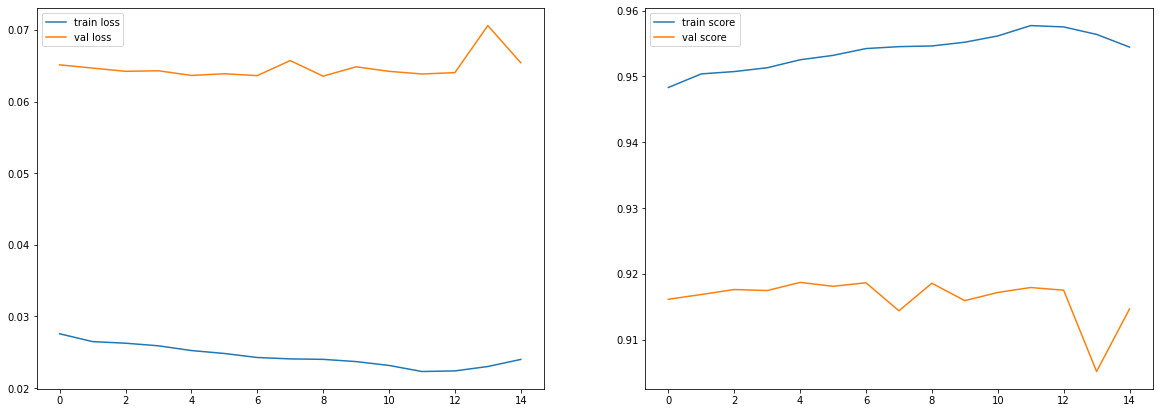


Epoch: 0
valid: 100%|██████████| 23/23 [00:04<00:00,  5.39it/s, dice_loss - 0.026, iou_score - 0.952]
Model saved!


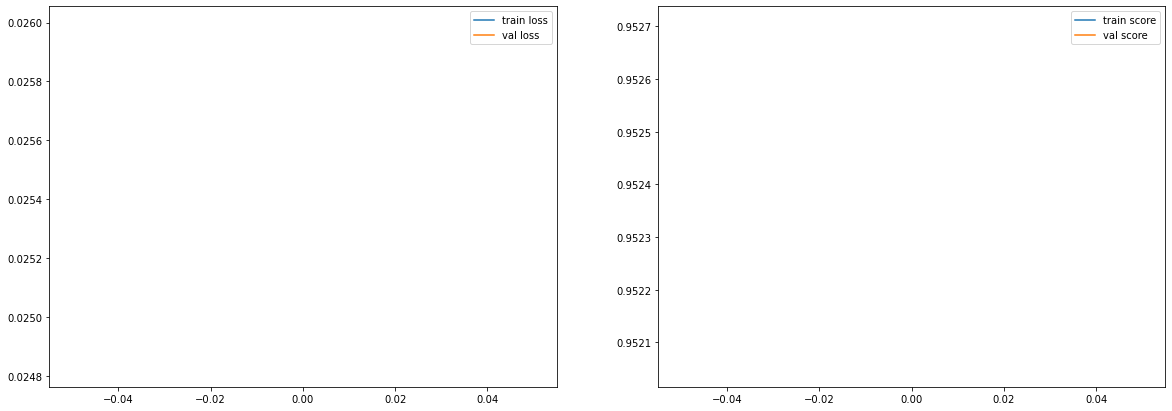


Epoch: 1
valid: 100%|██████████| 23/23 [00:05<00:00,  4.42it/s, dice_loss - 0.02644, iou_score - 0.9511]


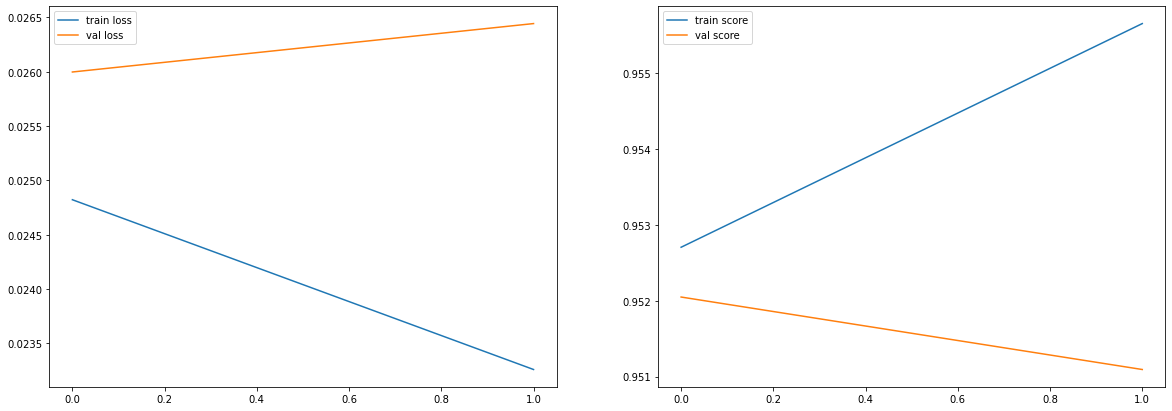


Epoch: 2
valid: 100%|██████████| 23/23 [00:04<00:00,  5.43it/s, dice_loss - 0.02523, iou_score - 0.9535]
Model saved!


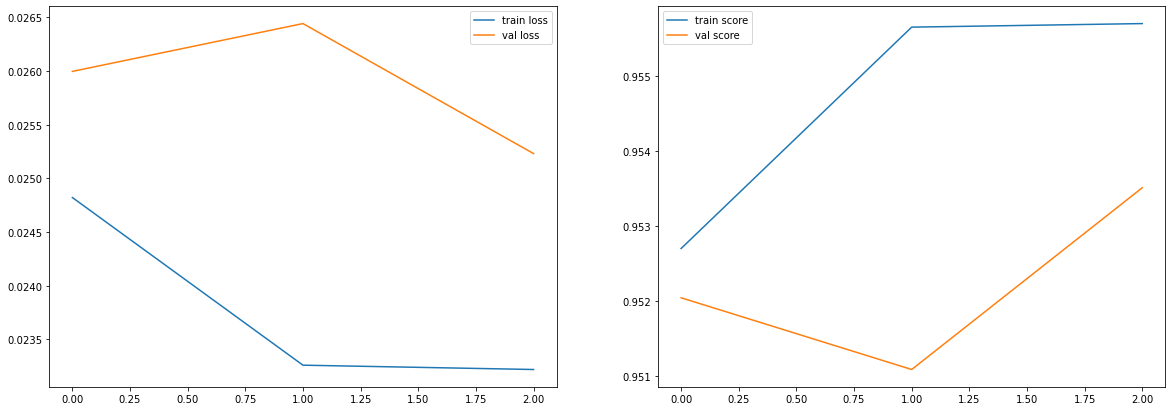


Epoch: 3
valid: 100%|██████████| 23/23 [00:05<00:00,  4.21it/s, dice_loss - 0.02482, iou_score - 0.9541]
Model saved!


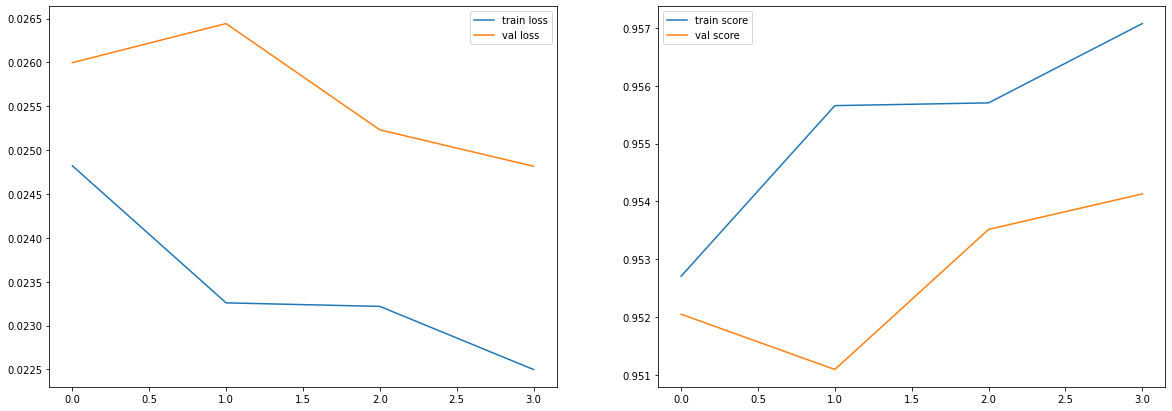


Epoch: 4
valid: 100%|██████████| 23/23 [00:04<00:00,  4.86it/s, dice_loss - 0.02529, iou_score - 0.9533]


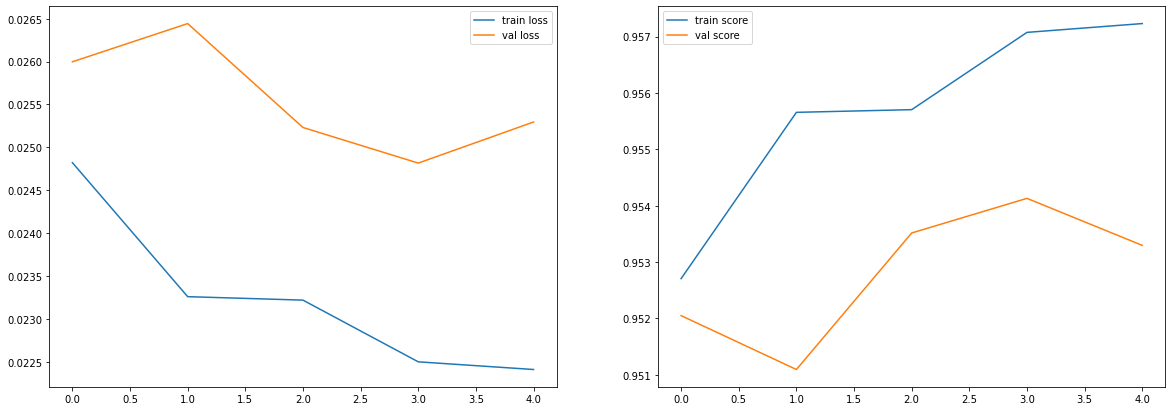


Epoch: 5
valid: 100%|██████████| 23/23 [00:04<00:00,  5.29it/s, dice_loss - 0.02463, iou_score - 0.9546]
Model saved!


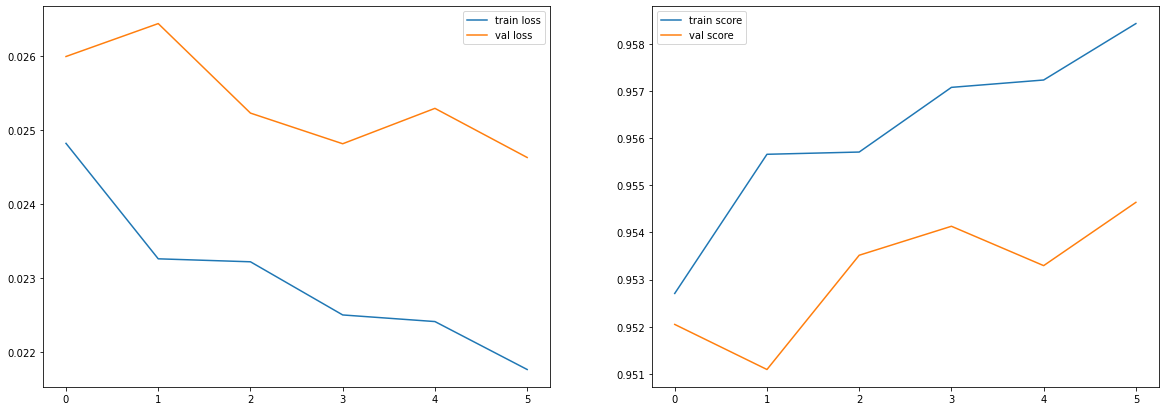


Epoch: 6
valid: 100%|██████████| 23/23 [00:04<00:00,  5.39it/s, dice_loss - 0.02491, iou_score - 0.9539]


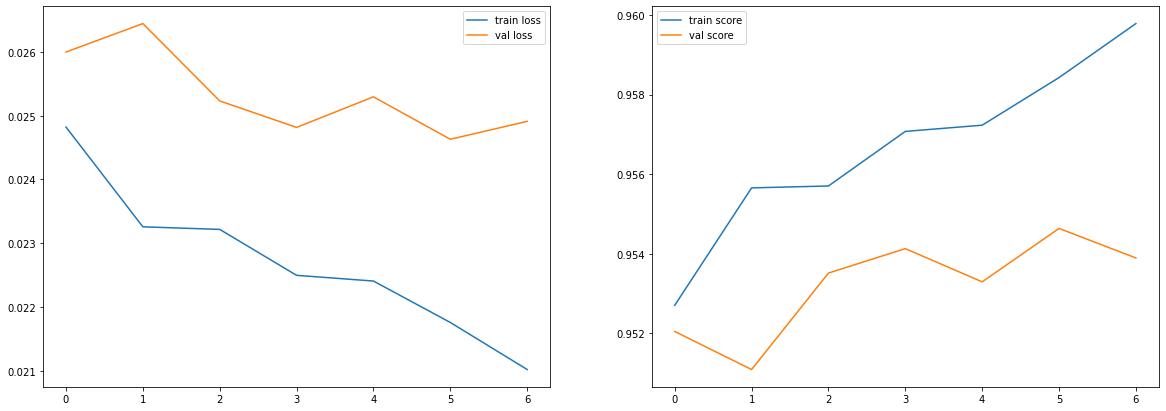


Epoch: 7
valid: 100%|██████████| 23/23 [00:04<00:00,  5.27it/s, dice_loss - 0.02598, iou_score - 0.9518]


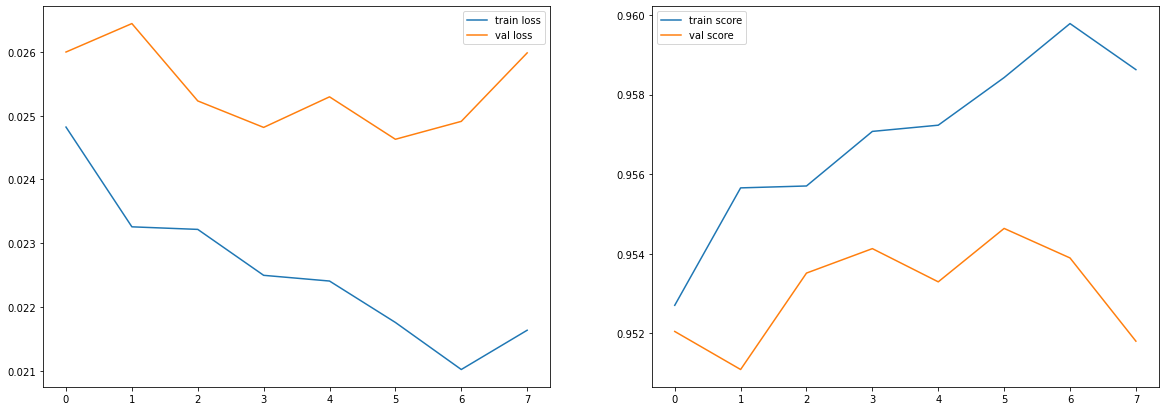


Epoch: 8
valid: 100%|██████████| 23/23 [00:04<00:00,  4.95it/s, dice_loss - 0.0254, iou_score - 0.9528]


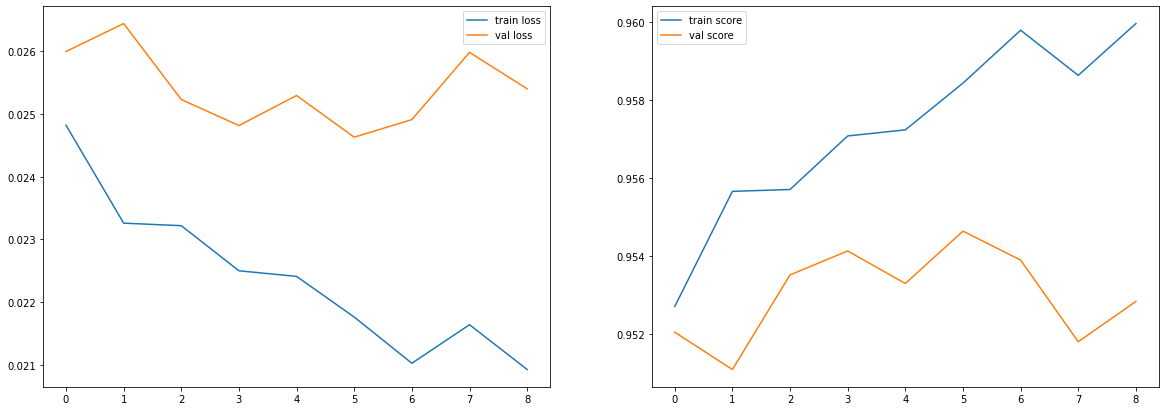


Epoch: 9
valid: 100%|██████████| 23/23 [00:04<00:00,  4.97it/s, dice_loss - 0.02459, iou_score - 0.9545]
Model saved!


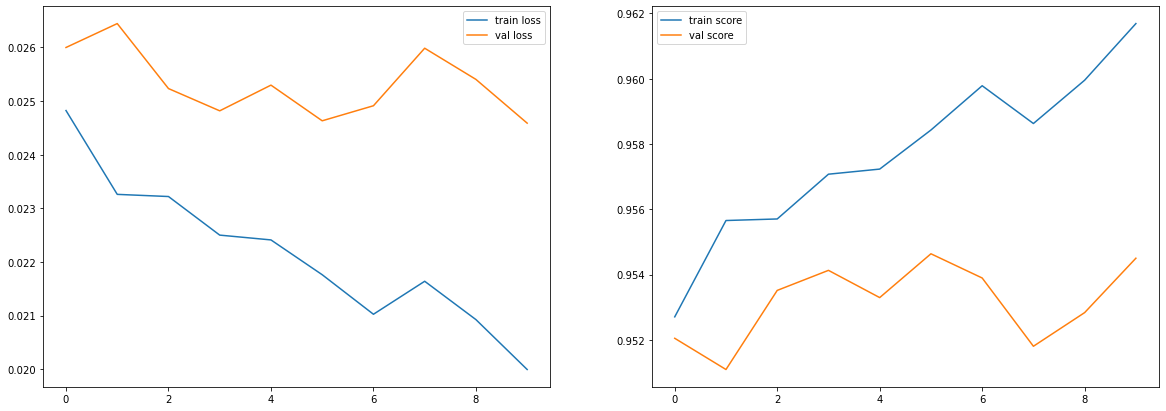


Epoch: 10
valid: 100%|██████████| 23/23 [00:05<00:00,  4.49it/s, dice_loss - 0.02535, iou_score - 0.9528]


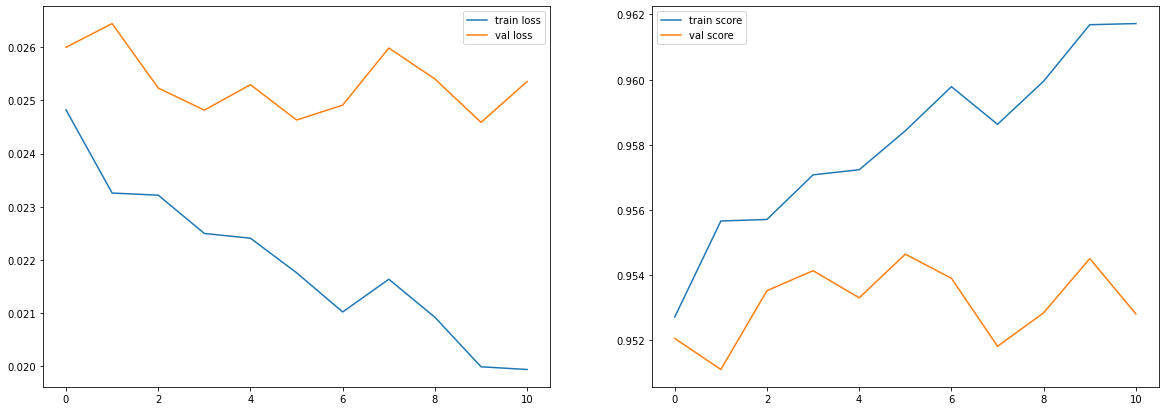


Epoch: 11
valid: 100%|██████████| 23/23 [00:04<00:00,  4.60it/s, dice_loss - 0.02481, iou_score - 0.9539]


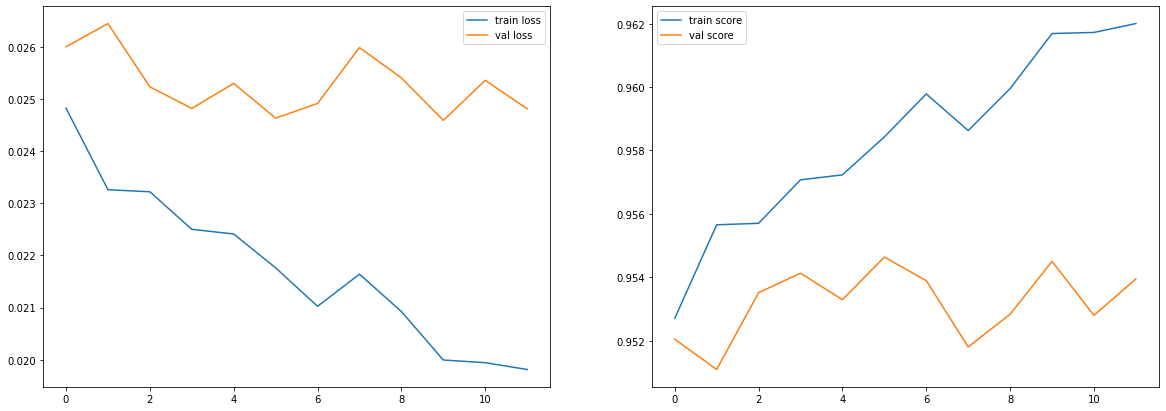


Epoch: 12
valid: 100%|██████████| 23/23 [00:04<00:00,  5.33it/s, dice_loss - 0.0268, iou_score - 0.9499]


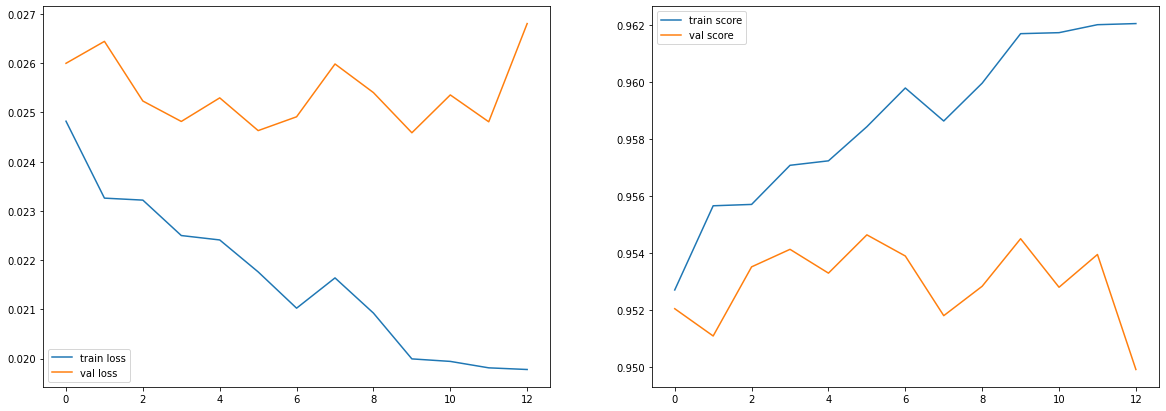


Epoch: 13
valid: 100%|██████████| 23/23 [00:04<00:00,  5.06it/s, dice_loss - 0.02527, iou_score - 0.953]


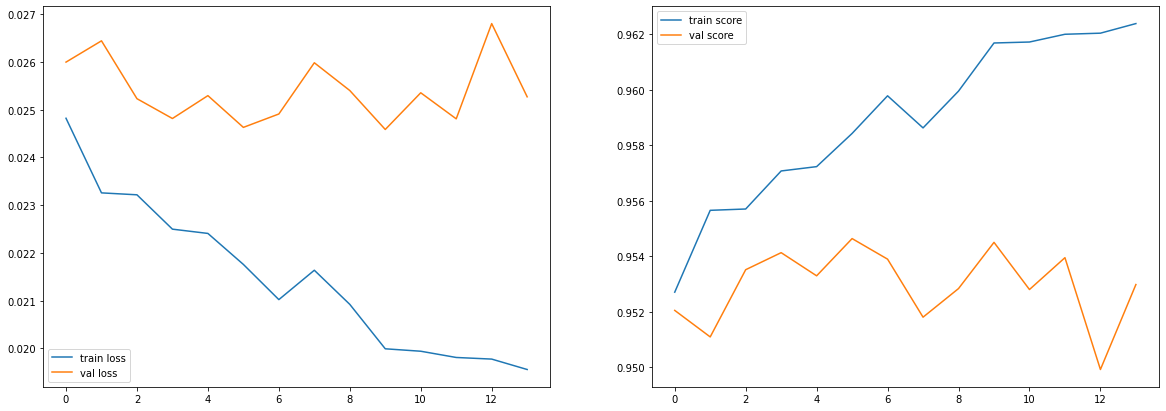


Epoch: 14
valid: 100%|██████████| 23/23 [00:05<00:00,  4.40it/s, dice_loss - 0.02551, iou_score - 0.9524]


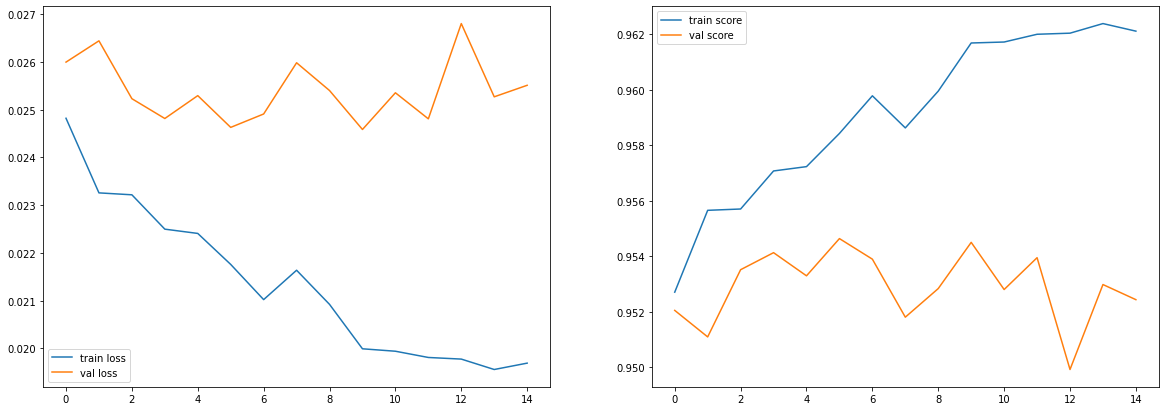

In [16]:
skf = KFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)
for fold,(train_idx, valid_idx) in enumerate(skf.split(ds)):
    #dataset
    train_ds = D.Subset(ds, train_idx)
    valid_ds = D.Subset(ds, valid_idx)
    
    #dataloader
    train_loader = D.DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
    val_loader = D.DataLoader(
        valid_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=NUM_WORKERS)
    
    #train   
    best_loss = 1.0
    train_losses, val_losses = [], []
    train_scores, val_scores = [], []
    for i in range(0, EPOCHS):
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(val_loader)

        train_losses.append(train_logs['dice_loss'])
        val_losses.append(valid_logs['dice_loss'])
        train_scores.append(train_logs['iou_score'])
        val_scores.append(valid_logs['iou_score'])

        if best_loss > valid_logs['dice_loss']:
            best_loss = valid_logs['dice_loss']
            torch.save(model, os.path.join(SAVE_DIR, f'best_model_{fold}.pth'))
            print('Model saved!')
            
        #plot
        plt.figure(figsize=(20,7))
        plt.subplot(121)
        plt.plot(train_losses, label='train loss')
        plt.plot(val_losses, label='val loss')
        plt.legend()

        plt.subplot(122)
        plt.plot(train_scores, label='train score')
        plt.plot(val_scores, label='val score')
        plt.legend()
        plt.show();

In [17]:
best_model = torch.load(os.path.join(SAVE_DIR, 'best_model_1.pth'), map_location=torch.device(DEVICE))

In [18]:
best_model.eval()

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        